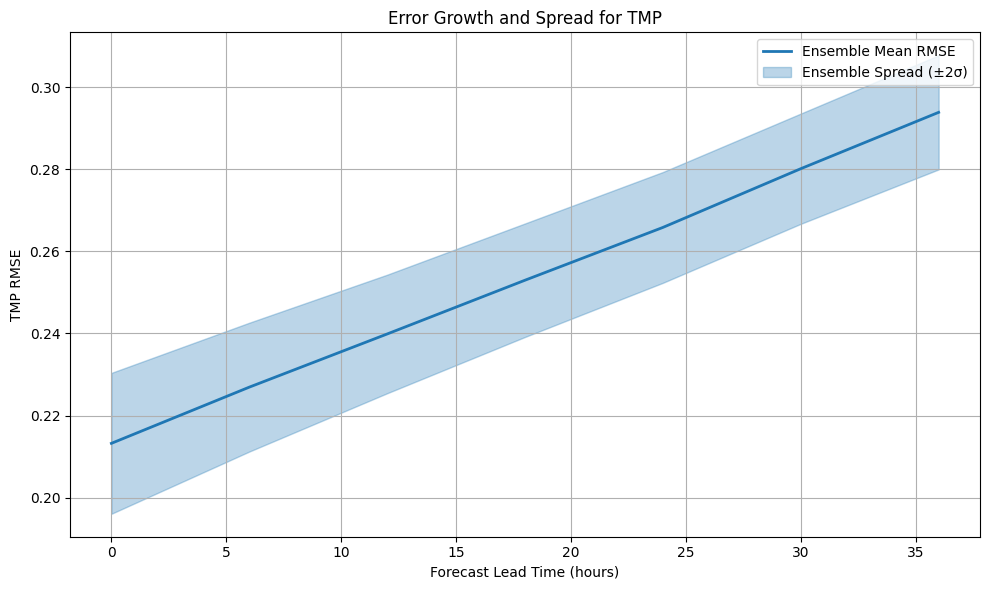

In [14]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# === Settings ===
diff_dir = "/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control"
members = [f"mem{str(i).zfill(3)}" for i in range(2, 81)]
times = range(3, 10)
var_name = "tmp"

# === Collect RMSEs ===
rmse_all = []
valid_times = []

for t_idx, t in enumerate(times):
    member_rmses = []

    for m in members:
        file = os.path.join(diff_dir, f"diff_{m}_cubed_sphere_grid_atmf00{t}.nc")
        if os.path.exists(file):
            ds = xr.open_dataset(file)
            if var_name in ds:
                diff = ds[var_name]

                # Collapse all dimensions except time
                rms = np.sqrt((diff**2).mean(dim=[k for k in diff.dims if k != "time"])).item()
                member_rmses.append(rms)

    if len(member_rmses) > 1:
        rmse_all.append(member_rmses)
        valid_times.append(t)

# === Convert to arrays ===
rmse_mean = np.array([np.mean(row) for row in rmse_all])
rmse_spread = np.array([np.std(row) for row in rmse_all])
time_hours = [(t - 3) * 6 for t in valid_times]

# === Plot with spread as shading ===
plt.figure(figsize=(10, 6))

# Plot mean line
plt.plot(time_hours, rmse_mean, label="Ensemble Mean RMSE", color="C0", linewidth=2)

# Shading for ±1 std dev (spread)
plt.fill_between(
    time_hours,
    rmse_mean - rmse_spread * 2,
    rmse_mean + rmse_spread * 2,
    color="C0",
    alpha=0.3,
    label="Ensemble Spread (±2σ)"
)

plt.xlabel("Forecast Lead Time (hours)")
plt.ylabel(f"{var_name.upper()} RMSE")
plt.title(f"Error Growth and Spread for {var_name.upper()}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
import xarray as xr

test_file = "/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf003.nc"
ds = xr.open_dataset(test_file)

print("Variables:", list(ds.data_vars))
print("Dimensions:", ds.dims)
print("Shape of a sample variable (e.g., T):", ds["T"].shape if "T" in ds else "Not found")

Variables: ['time_iso', 'clwmr', 'delz', 'dpres', 'dzdt', 'grle', 'hgtsfc', 'icmr', 'nccice', 'nconrd', 'o3mr', 'omga', 'pressfc', 'rwmr', 'snmr', 'spfh', 'tmp', 'ugrd', 'vgrd']
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 1, 'grid_xt': 48, 'grid_yt': 48, 'pfull': 127, 'tile': 6})
Shape of a sample variable (e.g., T): Not found


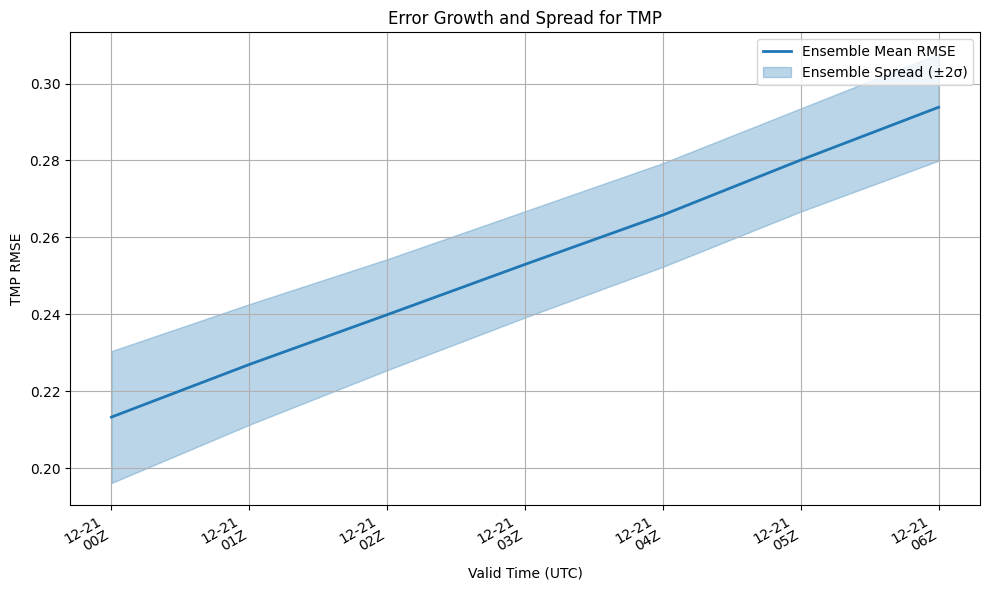

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# === Settings ===
diff_dir = "/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control"
members = [f"mem{str(i).zfill(3)}" for i in range(2, 81)]
times = range(3, 10)
var_name = "tmp"

# === Collect RMSEs ===
rmse_all = []
valid_times = []

for t_idx, t in enumerate(times):
    member_rmses = []

    for m in members:
        file = os.path.join(diff_dir, f"diff_{m}_cubed_sphere_grid_atmf00{t}.nc")
        if os.path.exists(file):
            ds = xr.open_dataset(file)
            if var_name in ds:
                diff = ds[var_name]

                # Collapse all dimensions except time
                rms = np.sqrt((diff**2).mean(dim=[k for k in diff.dims if k != "time"])).item()
                member_rmses.append(rms)

    if len(member_rmses) > 1:
        rmse_all.append(member_rmses)
        valid_times.append(t)

from datetime import datetime, timedelta

init_time = datetime(2021, 12, 20, 21)  # initial analysis time
forecast_datetimes = [init_time + timedelta(hours=t) for t in valid_times]

# === Convert to arrays ===
rmse_mean = np.array([np.mean(row) for row in rmse_all])
rmse_spread = np.array([np.std(row) for row in rmse_all])

plt.figure(figsize=(10, 6))

# Plot RMSE mean
plt.plot(forecast_datetimes, rmse_mean, label="Ensemble Mean RMSE", color="C0", linewidth=2)

# Shading for ±2σ
plt.fill_between(
    forecast_datetimes,
    rmse_mean - rmse_spread * 2,
    rmse_mean + rmse_spread * 2,
    color="C0",
    alpha=0.3,
    label="Ensemble Spread (±2σ)"
)

plt.xlabel("Valid Time (UTC)")
plt.ylabel(f"{var_name.upper()} RMSE")
plt.title(f"Error Growth and Spread for {var_name.upper()}")

# Improve time axis formatting
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%HZ'))
plt.gcf().autofmt_xdate()

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# === Settings ===
diff_dir = "/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control"
members = [f"mem{str(i).zfill(3)}" for i in range(2, 81)]
times = range(3, 10)
var_name = "tmp"
epsilon = 1e-6  # Prevent division by zero

# === Collect Normalized RMSEs ===
rmse_all = []
valid_times = []

for t_idx, t in enumerate(times):
    member_rmses = []

    for m in members:
        file = os.path.join(diff_dir, f"diff_{m}_cubed_sphere_grid_atmf00{t}.nc")
        if os.path.exists(file):
            ds = xr.open_dataset(file)
            if var_name in ds:
                diff = ds[var_name]

                # Normalize by the mean absolute value (over non-time dims)
                norm = np.abs(ds[var_name]).mean(dim=[k for k in diff.dims if k != "time"]) + epsilon
                rel_diff = diff / norm

                # Compute RMSE over space (excluding time)
                rms = np.sqrt((rel_diff**2).mean(dim=[k for k in rel_diff.dims if k != "time"])).item()
                member_rmses.append(rms)

    if len(member_rmses) > 1:
        rmse_all.append(member_rmses)
        valid_times.append(t)

# === Convert times ===
init_time = datetime(2021, 12, 20, 21)  # initial analysis time
forecast_datetimes = [init_time + timedelta(hours=t) for t in valid_times]

# === Convert to arrays ===
rmse_mean = np.array([np.mean(row) for row in rmse_all])
rmse_spread = np.array([np.std(row) for row in rmse_all])

# === Plot ===
plt.figure(figsize=(10, 6))

# Plot RMSE mean
plt.plot(forecast_datetimes, rmse_mean, label="Ensemble Mean Normalized RMSE", color="C0", linewidth=2)

# Shading for ±2σ
plt.fill_between(
    forecast_datetimes,
    rmse_mean - rmse_spread * 2,
    rmse_mean + rmse_spread * 2,
    color="C0",
    alpha=0.3,
    label="Ensemble Spread (±2σ)"
)

plt.xlabel("Valid Time (UTC)")
plt.ylabel(f"Normalized RMSE of {var_name.upper()}")
plt.title(f"Normalized Error Growth and Spread for {var_name.upper()}")

# Improve time axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%HZ'))
plt.gcf().autofmt_xdate()

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
import os
from netCDF4 import Dataset

path = "/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/jedi-bundle/build/fv3-jedi/test/Data/merged/merged_3_lvls/raw_files"

for fname in os.listdir(path):
    if fname.endswith(".nc"):
        fullpath = os.path.join(path, fname)
        print(f"Processing {fname}")
        # Create a backup
        backup = fullpath + ".bak"
        if not os.path.exists(backup):
            os.system(f"cp {fullpath} {backup}")

        try:
            with Dataset(fullpath, mode='r+') as ds:
                if "lat" in ds.variables:
                    print("  Renaming lat → lats")
                    ds.renameVariable("lat", "lats")
                if "lon" in ds.variables:
                    print("  Renaming lon → lons")
                    ds.renameVariable("lon", "lons")
        except Exception as e:
            print(f"  ⚠️ Failed on {fname}: {e}")

Processing hybrid_linear_model_coeffs_20211221T020000Z_000216-000139.nc
  Renaming lat → lats
  Renaming lon → lons
Processing hybrid_linear_model_coeffs_20211221T000000Z_000216-000054.nc
  Renaming lat → lats
  Renaming lon → lons
Processing hybrid_linear_model_coeffs_20211221T010000Z_000216-000181.nc
  Renaming lat → lats
  Renaming lon → lons
Processing hybrid_linear_model_coeffs_20211220T220000Z_000216-000094.nc
  Renaming lat → lats
  Renaming lon → lons
Processing hybrid_linear_model_coeffs_20211221T000000Z_000216-000094.nc
  Renaming lat → lats
  Renaming lon → lons
Processing hybrid_linear_model_coeffs_20211221T020000Z_000216-000099.nc
  Renaming lat → lats
  Renaming lon → lons
Processing hybrid_linear_model_coeffs_20211220T220000Z_000216-000039.nc
  Renaming lat → lats
  Renaming lon → lons
Processing hybrid_linear_model_coeffs_20211220T220000Z_000216-000091.nc
  Renaming lat → lats
  Renaming lon → lons
Processing hybrid_linear_model_coeffs_20211221T020000Z_000216-000012.nc


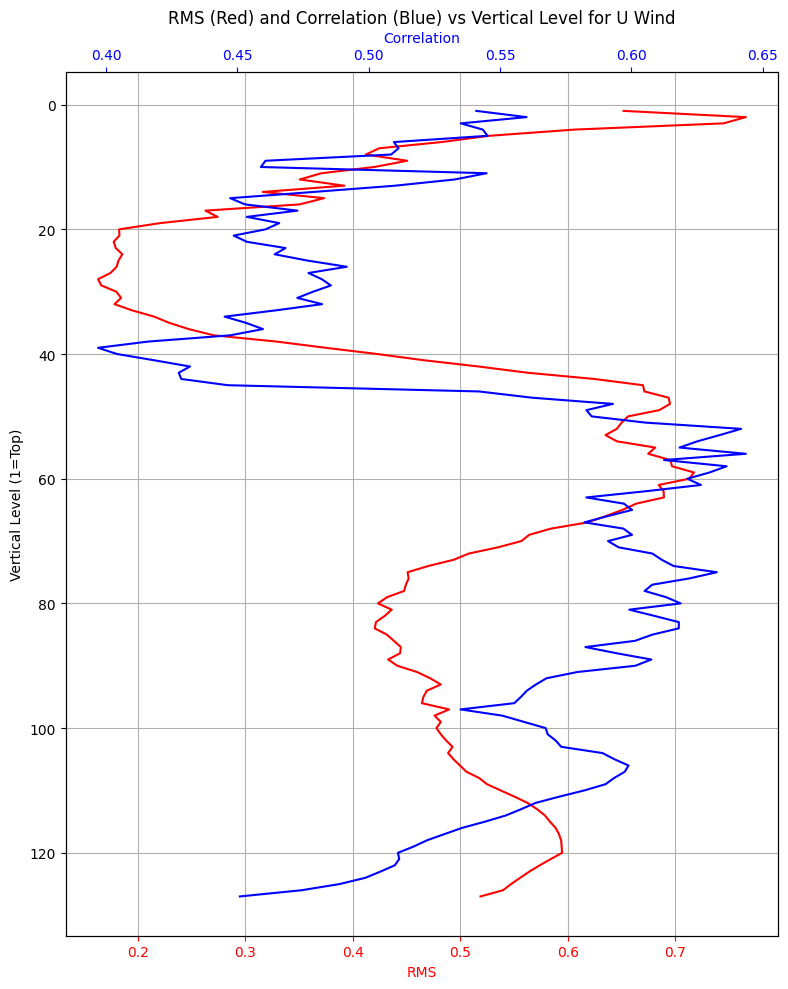

In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['ugrd'].astype(np.float64)
ugrd2 = ds2['ugrd'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for U Wind')
plt.tight_layout()
plt.show()

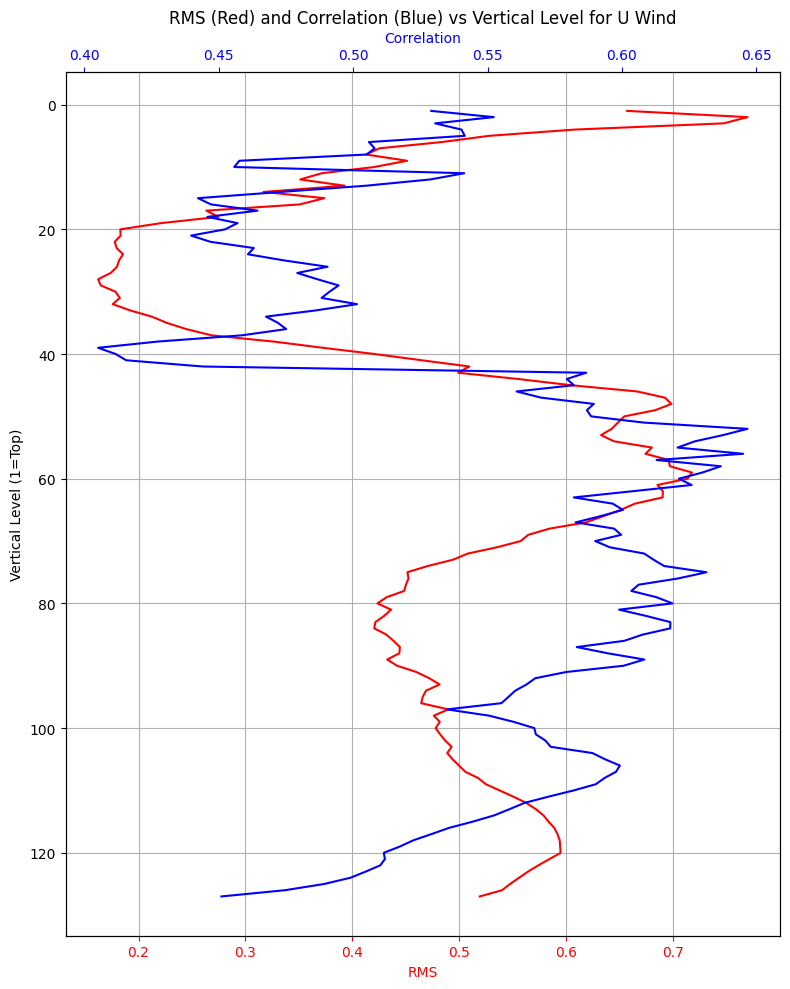

In [51]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem2_change_params.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['ugrd'].astype(np.float64)
ugrd2 = ds2['ugrd'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for U Wind')
plt.tight_layout()
plt.show()

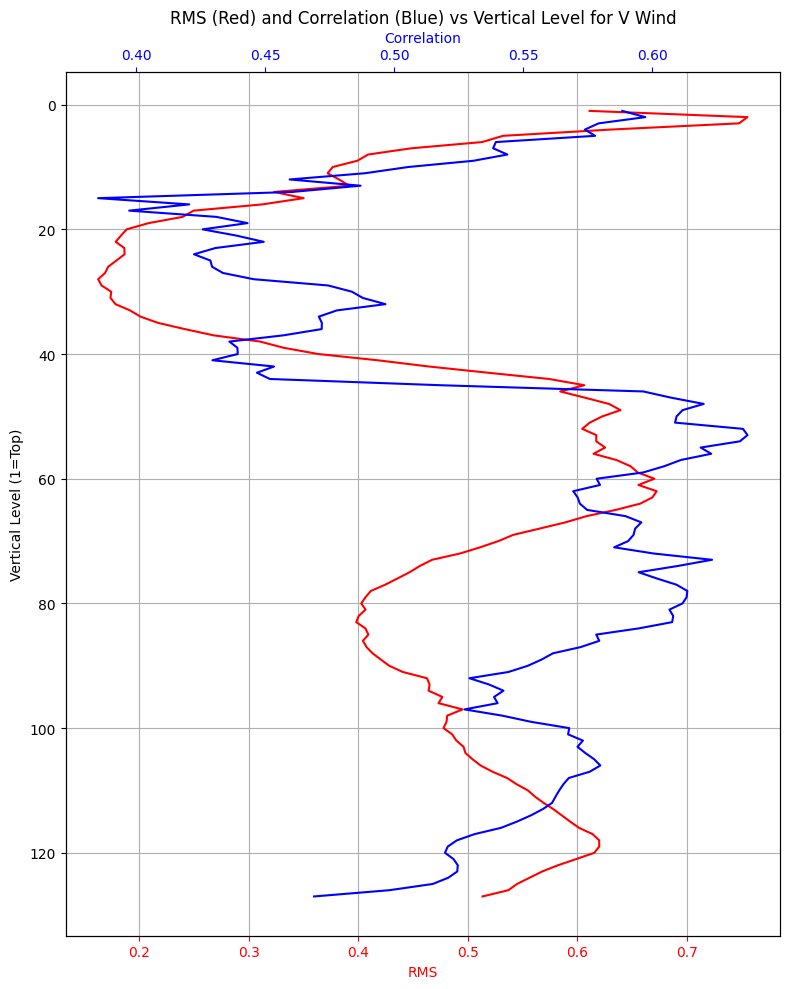

In [25]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['vgrd'].astype(np.float64)
ugrd2 = ds2['vgrd'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for V Wind')
plt.tight_layout()
plt.show()

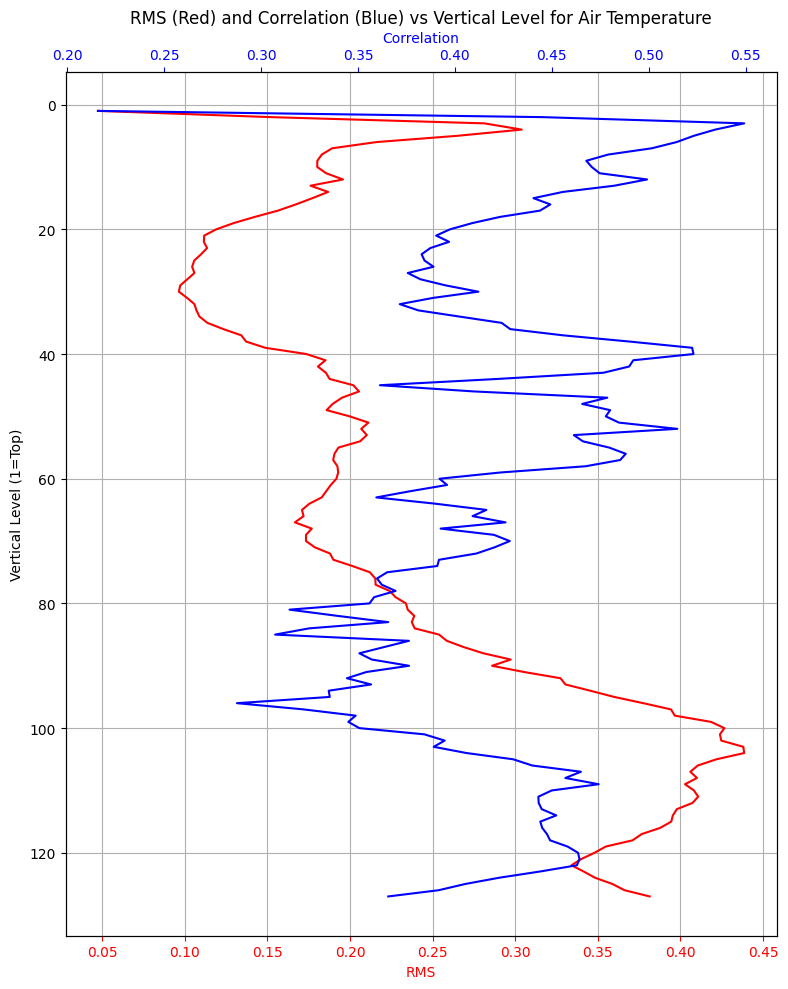

In [26]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['tmp'].astype(np.float64)
ugrd2 = ds2['tmp'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for Air Temperature')
plt.tight_layout()
plt.show()

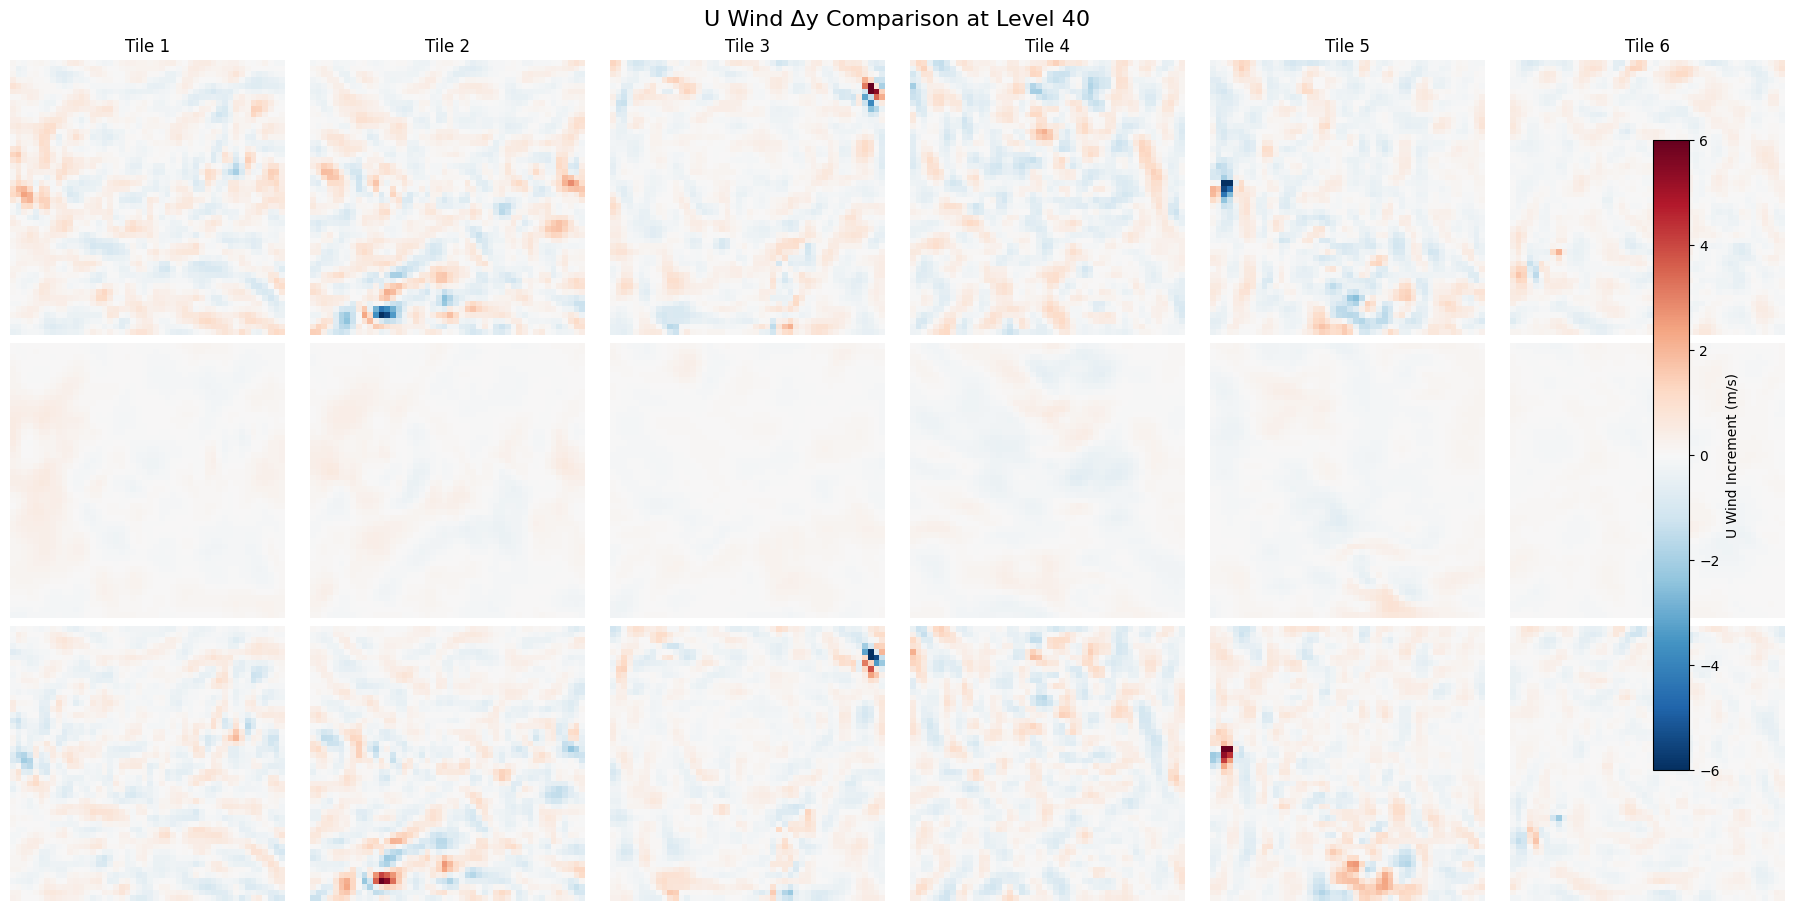

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# === Choose level (index, not value) ===
level_idx = 39  # Python 0-indexed: pfull[39] is level 40

# === Extract fields ===
dy_true = ugrd2.isel(pfull=level_idx)  # [tile, y, x]
dy_tlm  = ugrd1.isel(pfull=level_idx)  # [tile, y, x]
dy_diff = dy_tlm - dy_true             # difference field

# === Plotting ===
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 9), constrained_layout=True)
fields = [dy_true, dy_tlm, dy_diff]
titles = ['Δy True (Ensemble)', 'Δy TLM', 'TLM - True']

vmin = float(min([f.min().values for f in fields]))
vmax = float(max([f.max().values for f in fields]))

for row in range(3):  # 3 rows: True, TLM, Diff
    for tile in range(6):  # 6 cubed-sphere tiles
        ax = axes[row, tile]
        im = ax.imshow(fields[row].isel(tile=tile), cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.set_title(f"Tile {tile+1}" if row == 0 else "")
        ax.axis('off')

    # Label the row
    axes[row, 0].set_ylabel(titles[row], fontsize=12)

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='U Wind Increment (m/s)')

plt.suptitle(f'U Wind Δy Comparison at Level {level_idx+1}', fontsize=16)
plt.show()

In [28]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata

def plot_cubed_sphere_field(var, lat, lon, level_idx=39, title="", outname=None):
    """
    Plots a single variable from cubed-sphere (ugrd-like) on a global lat/lon grid using Cartopy.
    
    Parameters:
        var      : xarray.DataArray with dims [tile, pfull, y, x]
        lat/lon  : xarray.DataArray with dims [tile, y, x]
        level_idx: which vertical level to plot (0-indexed)
        title    : plot title
        outname  : optional path to save the figure
    """
    # Extract level
    data = var.isel(pfull=level_idx).values  # shape: [tile, y, x]
    lat_vals = lat.values
    lon_vals = lon.values

    # Flatten all tiles
    lon_flat = lon_vals.reshape(-1)
    lat_flat = lat_vals.reshape(-1)
    data_flat = data.reshape(-1)

    # Duplicate across seam
    lon_ext = np.concatenate([lon_flat, lon_flat - 360])
    lat_ext = np.concatenate([lat_flat, lat_flat])
    data_ext = np.concatenate([data_flat, data_flat])

    # Interpolate to regular grid
    lon_grid, lat_grid = np.meshgrid(np.linspace(-180, 180, 720), np.linspace(-90, 90, 361))
    field_interp = griddata(
        (lon_ext, lat_ext), data_ext,
        (lon_grid, lat_grid),
        method='linear'
    )

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    pcm = ax.pcolormesh(lon_grid, lat_grid, field_interp,
                        cmap="RdBu_r", shading="auto", transform=ccrs.PlateCarree())
    ax.set_title(title)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    fig.colorbar(pcm, ax=ax, orientation="vertical", label="m/s")

    if outname:
        plt.savefig(outname, dpi=300)
        print(f"✅ Saved to {outname}")
    else:
        plt.show()

✅ Saved to dy_true.png
✅ Saved to dy_tlm.png
✅ Saved to dy_diff.png


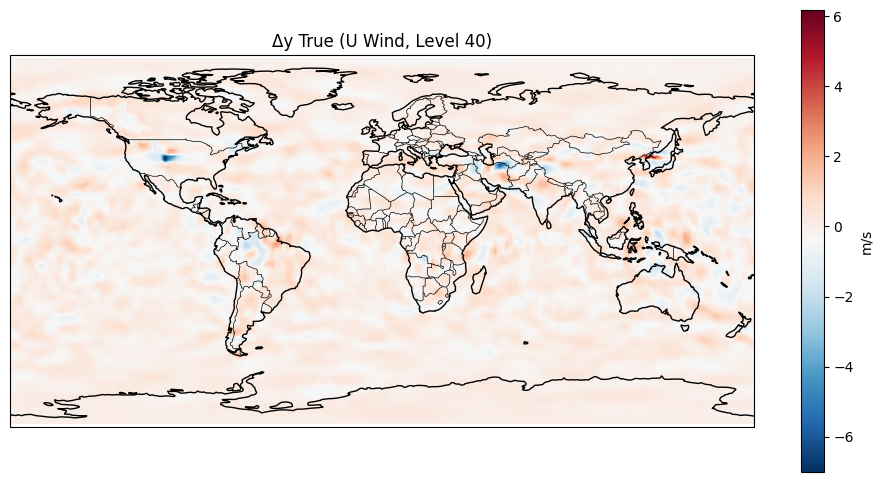

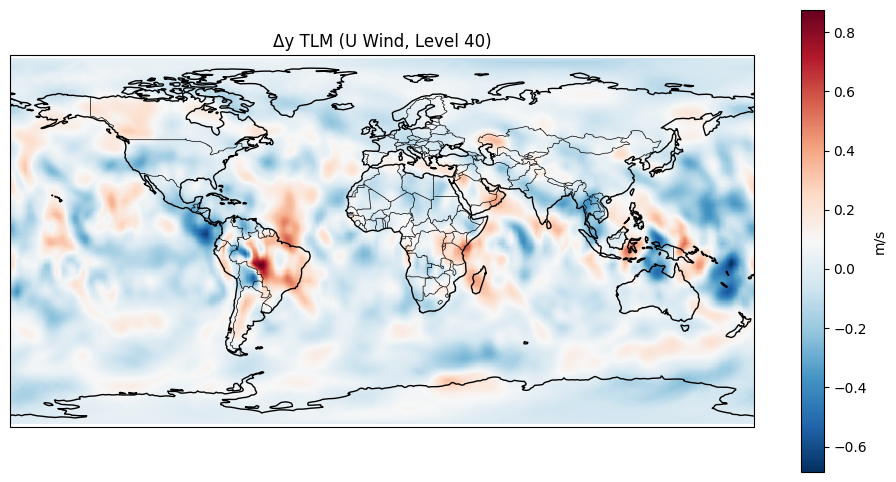

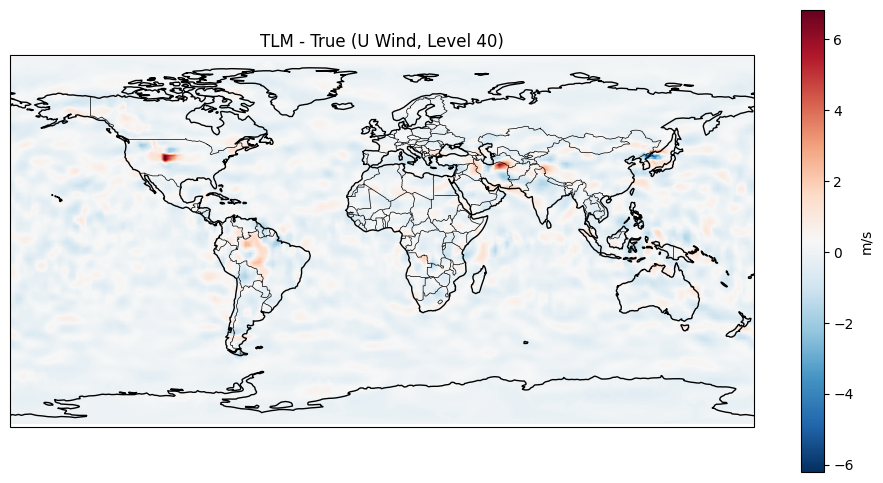

In [31]:
# After loading your files
ds1 = xr.open_dataset(file1)  # TLM
ds2 = xr.open_dataset(file2)  # Truth delta
ds1 = ds1.assign_coords(pfull=ds2['pfull'])
ugrd1 = ds1['ugrd'].astype(np.float64).isel(time=0)
ugrd2 = ds2['ugrd'].astype(np.float64).isel(time=0)
ugrd2 = xr.where(ugrd2 < 1e20, ugrd2, np.nan)

# Align vertical coordinate if needed
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

dy_tlm = ugrd1
dy_true = ugrd2
dy_diff = dy_tlm - dy_true

lat = ds1['lat']
lon = ds1['lon']

plot_cubed_sphere_field(dy_true, lat, lon, level_idx=39, title="Δy True (U Wind, Level 40)", outname="dy_true.png")
plot_cubed_sphere_field(dy_tlm, lat, lon, level_idx=39, title="Δy TLM (U Wind, Level 40)", outname="dy_tlm.png")
plot_cubed_sphere_field(dy_diff, lat, lon, level_idx=39, title="TLM - True (U Wind, Level 40)", outname="dy_diff.png")

In [50]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import os

def plot_cubed_sphere_field(var, lat, lon, level_idx=110, title="", outname=None, vmin=None, vmax=None):
    # Select level and merge tiles
    var_level = var.isel(pfull=level_idx).values  # shape: (tile, y, x)
    lat_vals = lat.values
    lon_vals = lon.values
    ntiles, ny, nx = var_level.shape

    # Flatten all tiles
    field_all = []
    lat_all = []
    lon_all = []

    for t in range(ntiles):
        field_all.append(var_level[t].ravel())
        lat_all.append(lat_vals[t].ravel())
        lon_all.append(lon_vals[t].ravel())

    field = np.concatenate(field_all)
    lat_pts = np.concatenate(lat_all)
    lon_pts = np.concatenate(lon_all)

    # Duplicate around 360 seam
    lon_ext = np.concatenate([lon_pts, lon_pts - 360])
    lat_ext = np.concatenate([lat_pts, lat_pts])
    field_ext = np.concatenate([field, field])

    # Create target grid
    lon_target = np.linspace(-180, 180, 720)
    lat_target = np.linspace(-90, 90, 361)
    lon_grid, lat_grid = np.meshgrid(lon_target, lat_target)

    # Interpolate
    field_interp = griddata(
        (lon_ext, lat_ext), field_ext,
        (lon_grid, lat_grid),
        method='linear'
    )

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5),
                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    pcm = ax.pcolormesh(
        lon_grid, lat_grid, field_interp,
        cmap="RdBu_r", shading="auto", transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title)

    # Colorbar
    cb = plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.05)
    cb.set_label("m/s")

    # Save or show
    if outname:
        plt.savefig(outname, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {outname}")
    else:
        plt.show()
    plt.close()


# === Load datasets ===

tlm_file = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
true_file = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

ds_tlm = xr.open_dataset(tlm_file)
ds_true = xr.open_dataset(true_file)

# Use pfull from true file for consistency
ds_tlm = ds_tlm.assign_coords(pfull=ds_true['pfull'])

# Extract variables
ugrd_tlm = ds_tlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_true = ds_true['ugrd'].astype(np.float64).isel(time=0)

# Difference
ugrd_diff = ugrd_tlm - ugrd_true

# Common lat/lon
lat = ds_true['lat']
lon = ds_true['lon']

# === Compute shared colorbar range (symmetric) ===
all_vals = np.concatenate([
    ugrd_true.values.flatten(),
    ugrd_tlm.values.flatten()
])
abs_max = np.nanmax(np.abs(all_vals))
vmin, vmax = -6, 6

# === Plot each field ===
plot_cubed_sphere_field(ugrd_true, lat, lon, level_idx=110,
                        title="Δy True (U Wind, Level 110)",
                        outname="dy_true_level110.png",
                        vmin=vmin, vmax=vmax)

plot_cubed_sphere_field(ugrd_tlm, lat, lon, level_idx=110,
                        title="Δy TLM (U Wind, Level 110)",
                        outname="dy_tlm_level110.png",
                        vmin=vmin, vmax=vmax)

# Separate colorbar range for residuals (optional)
resid_max = np.nanmax(np.abs(ugrd_diff.values))
plot_cubed_sphere_field(ugrd_diff, lat, lon, level_idx=110,
                        title="TLM - True (U Wind, Level 110)",
                        outname="dy_diff_level110.png",
                        vmin=vmin, vmax=vmax)

✅ Saved: dy_true_level110.png
✅ Saved: dy_tlm_level110.png
✅ Saved: dy_diff_level110.png


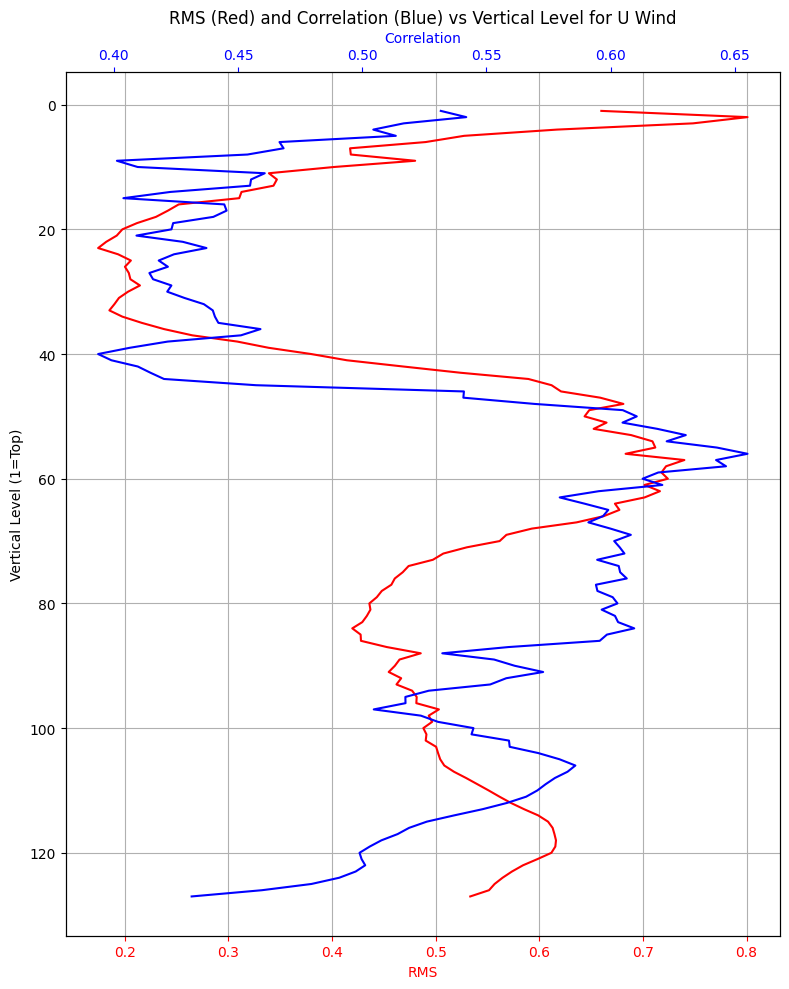

In [43]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem3.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem003_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['ugrd'].astype(np.float64)
ugrd2 = ds2['ugrd'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for U Wind')
plt.tight_layout()
plt.show()

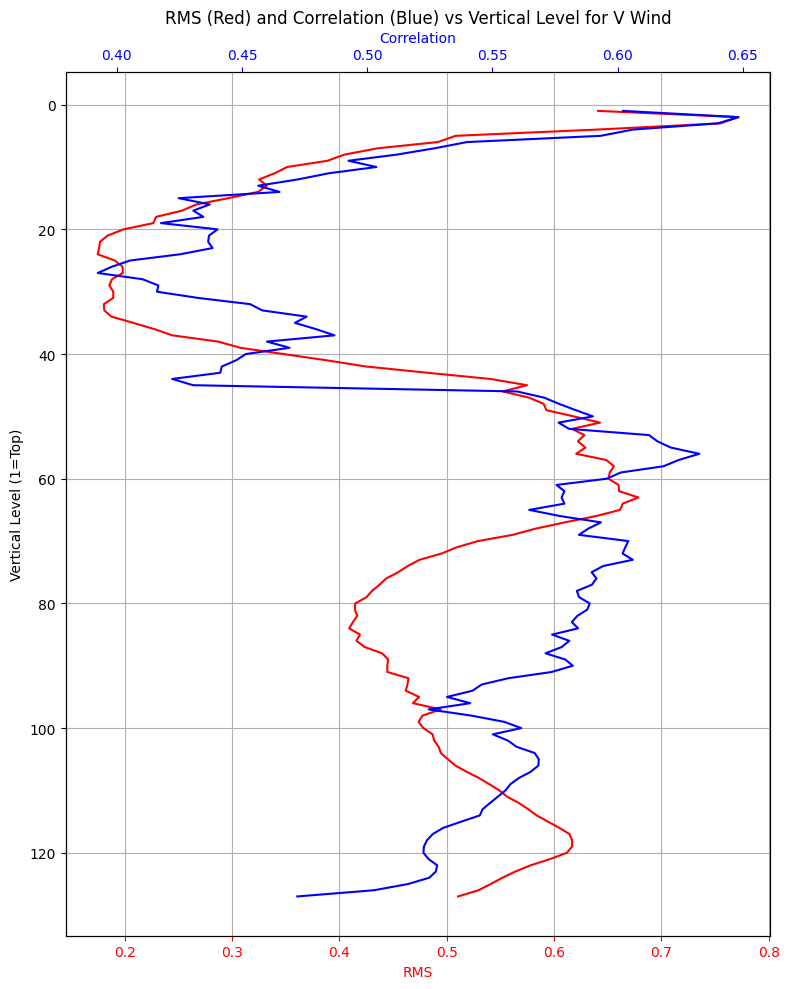

In [44]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem3.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem003_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['vgrd'].astype(np.float64)
ugrd2 = ds2['vgrd'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for V Wind')
plt.tight_layout()
plt.show()

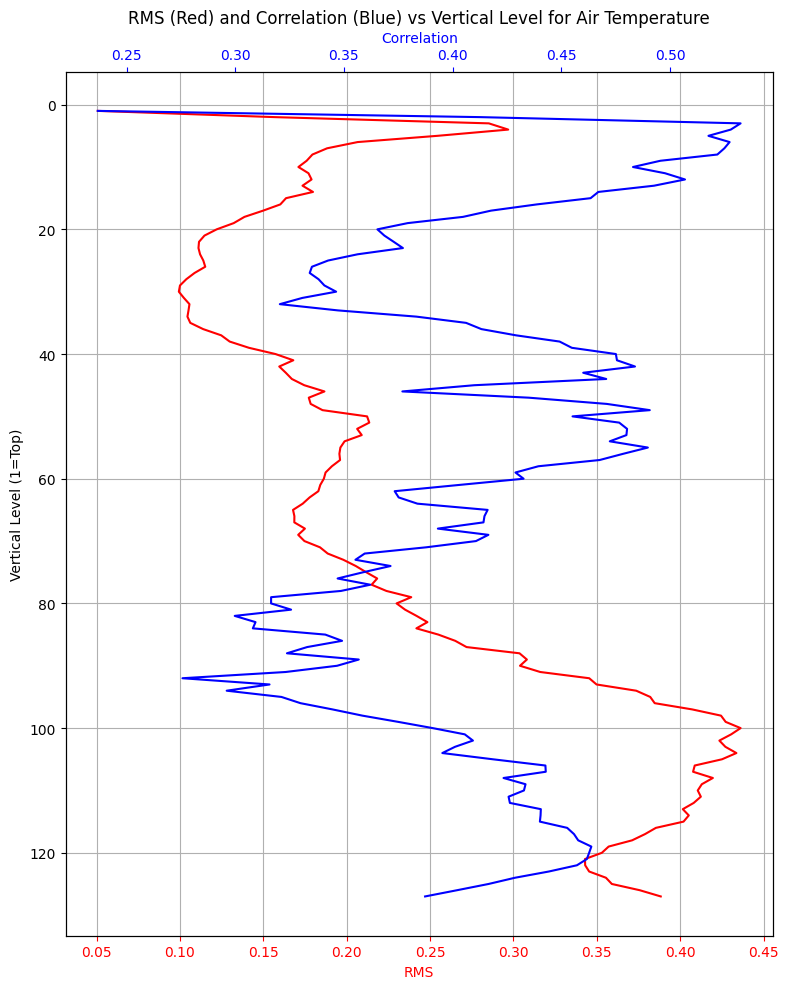

In [45]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem3.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem003_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['tmp'].astype(np.float64)
ugrd2 = ds2['tmp'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for Air Temperature')
plt.tight_layout()
plt.show()

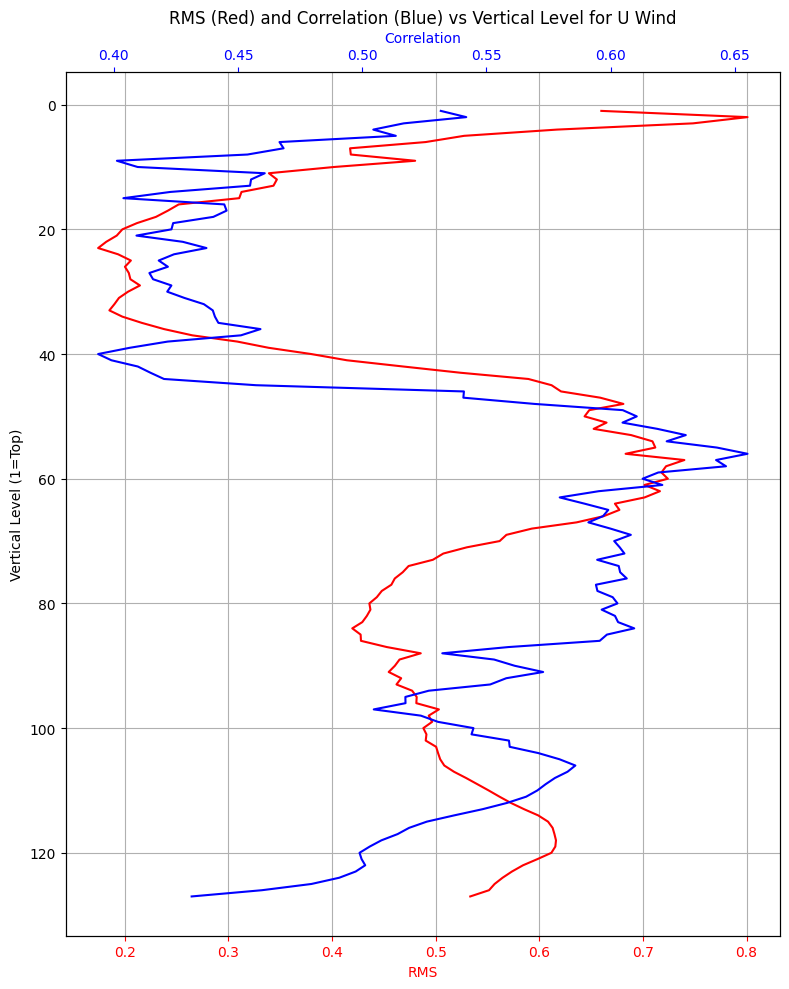

In [46]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem3_minus_physics.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem003_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['ugrd'].astype(np.float64)
ugrd2 = ds2['ugrd'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for U Wind')
plt.tight_layout()
plt.show()

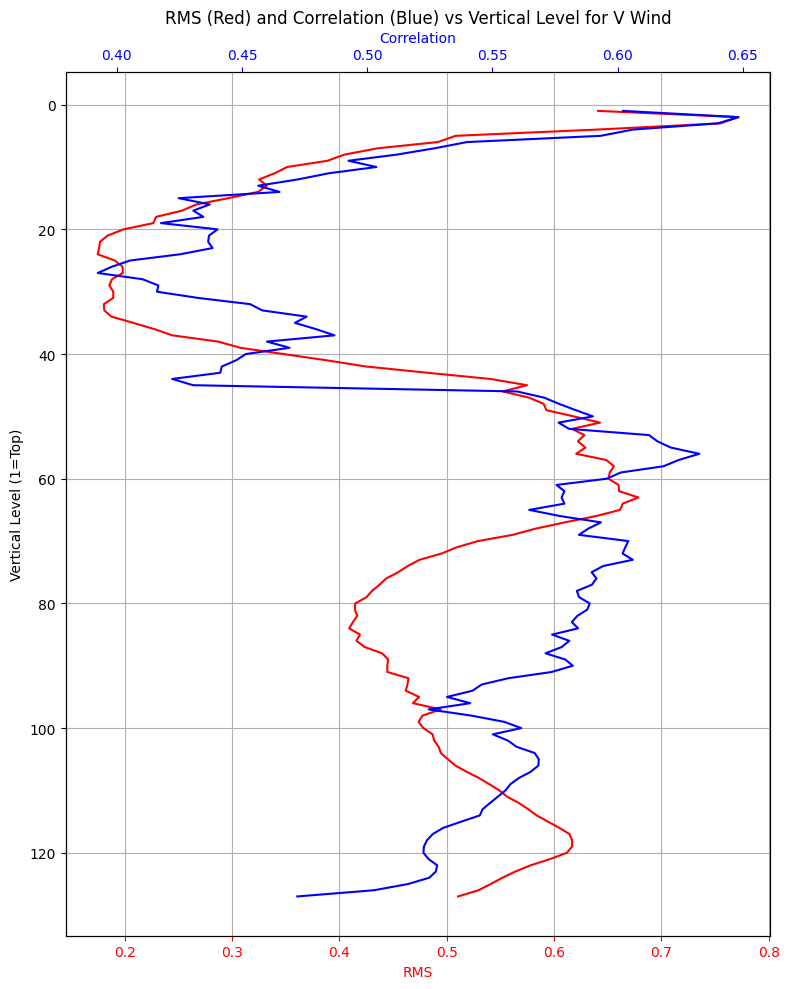

In [47]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem3_minus_physics.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem003_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['vgrd'].astype(np.float64)
ugrd2 = ds2['vgrd'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for V Wind')
plt.tight_layout()
plt.show()

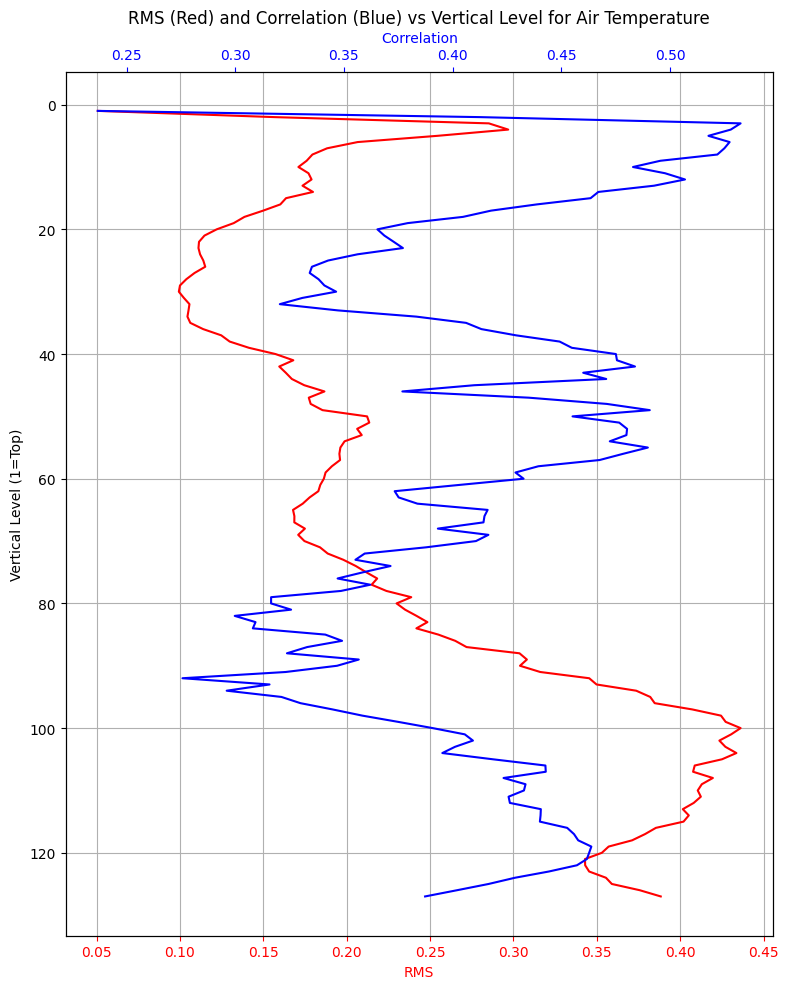

In [48]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load both datasets
file1 = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem3_minus_physics.nc'
file2 = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem003_cubed_sphere_grid_atmf009.nc'

ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Replace pfull in ds1 with pfull from ds2
ds1 = ds1.assign_coords(pfull=ds2['pfull'])

# Extract ugrd variable and convert to double precision for consistent math
ugrd1 = ds1['tmp'].astype(np.float64)
ugrd2 = ds2['tmp'].astype(np.float64)

# Match time dimension if needed (assuming first timestep)
ugrd1 = ugrd1.isel(time=0)
ugrd2 = ugrd2.isel(time=0)

# Sanity check on shape
assert ugrd1.shape == ugrd2.shape, "Mismatch in ugrd dimensions"

# Compute RMS and Correlation over grid_yt and grid_xt for each level and tile
rms = np.sqrt(((ugrd1 - ugrd2) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr = xr.corr(ugrd1, ugrd2, dim=('grid_yt', 'grid_xt'))

# Now average over the 6 tiles
rms_mean = rms.mean(dim='tile')
corr_mean = corr.mean(dim='tile')

# Convert level (pfull) to numpy array for plotting
levels = np.arange(1, len(rms['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 10))

# Primary x-axis for RMS
ax1.plot(rms_mean, levels, 'r-', label='RMS')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_mean, levels, 'b-', label='Correlation')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Title and layout
plt.title('RMS (Red) and Correlation (Blue) vs Vertical Level for Air Temperature')
plt.tight_layout()
plt.show()

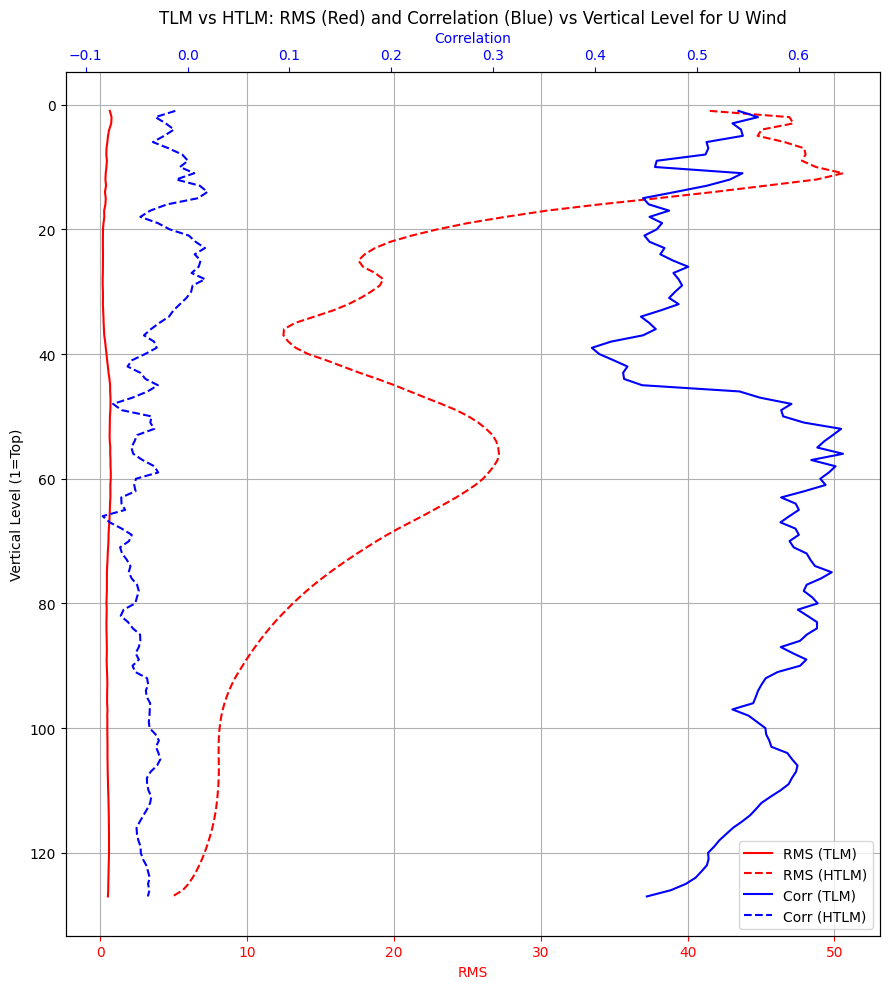

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2_HELP.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_truth = xr.open_dataset(file_truth)

# Replace pfull in forecasts with the one from truth to ensure alignment
ds_tlm = ds_tlm.assign_coords(pfull=ds_truth['pfull'])
ds_htlm = ds_htlm.assign_coords(pfull=ds_truth['pfull'])

# Extract ugrd variable and select first timestep
ugrd_truth = ds_truth['ugrd'].astype(np.float64).isel(time=0)
ugrd_tlm = ds_tlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_htlm = ds_htlm['ugrd'].astype(np.float64).isel(time=0)

# Check shapes match
assert ugrd_tlm.shape == ugrd_truth.shape == ugrd_htlm.shape, "Mismatch in shapes!"

# RMS and Correlation
rms_tlm = np.sqrt(((ugrd_tlm - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_tlm = xr.corr(ugrd_tlm, ugrd_truth, dim=('grid_yt', 'grid_xt'))

rms_htlm = np.sqrt(((ugrd_htlm - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_htlm = xr.corr(ugrd_htlm, ugrd_truth, dim=('grid_yt', 'grid_xt'))

# Average over tiles
rms_tlm_mean = rms_tlm.mean(dim='tile')
corr_tlm_mean = corr_tlm.mean(dim='tile')

rms_htlm_mean = rms_htlm.mean(dim='tile')
corr_htlm_mean = corr_htlm.mean(dim='tile')

# Plotting
levels = np.arange(1, len(rms_tlm['pfull']) + 1)

fig, ax1 = plt.subplots(figsize=(9, 10))

# RMS plots
ax1.plot(rms_tlm_mean, levels, 'r-', label='RMS (TLM)')
ax1.plot(rms_htlm_mean, levels, 'r--', label='RMS (HTLM)')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Twin x-axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_tlm_mean, levels, 'b-', label='Corr (TLM)')
ax2.plot(corr_htlm_mean, levels, 'b--', label='Corr (HTLM)')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

# Title and layout
plt.title('TLM vs HTLM: RMS (Red) and Correlation (Blue) vs Vertical Level for U Wind')
plt.tight_layout()
plt.show()

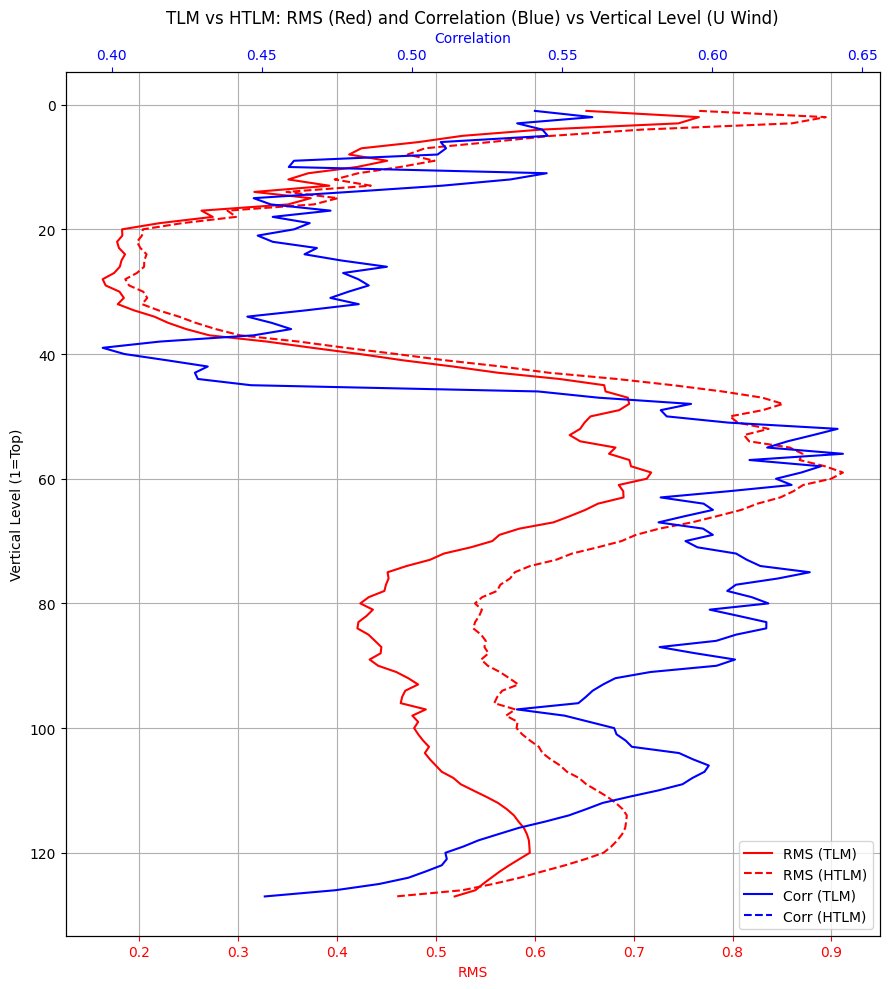

In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# File paths
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2_5_lvl.nc'
file_control = '//Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf009.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

# Load datasets
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_control = xr.open_dataset(file_control)
ds_truth = xr.open_dataset(file_truth)

# Replace pfull coordinates with those from truth for alignment
ds_tlm = ds_tlm.assign_coords(pfull=ds_truth['pfull'])
ds_htlm = ds_htlm.assign_coords(pfull=ds_truth['pfull'])
ds_control = ds_control.assign_coords(pfull=ds_truth['pfull'])

# Extract U wind component and convert to float64
ugrd_tlm = ds_tlm['ugrd'].astype(np.float64).isel(time=0)            # TLM is already differenced
ugrd_htlm = ds_htlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_ctrl = ds_control['ugrd'].astype(np.float64).isel(time=0)
ugrd_truth = ds_truth['ugrd'].astype(np.float64).isel(time=0)

# Compute HTLM - CONTROL
ugrd_htlm_delta = ugrd_htlm - ugrd_ctrl

# Sanity check
assert ugrd_tlm.shape == ugrd_htlm_delta.shape == ugrd_truth.shape, "Mismatch in shapes!"

# Compute RMS and correlation vs truth
rms_tlm = np.sqrt(((ugrd_tlm - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_tlm = xr.corr(ugrd_tlm, ugrd_truth, dim=('grid_yt', 'grid_xt'))

rms_htlm = np.sqrt(((ugrd_htlm_delta - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_htlm = xr.corr(ugrd_htlm_delta, ugrd_truth, dim=('grid_yt', 'grid_xt'))

# Average over the 6 tiles
rms_tlm_mean = rms_tlm.mean(dim='tile')
corr_tlm_mean = corr_tlm.mean(dim='tile')

rms_htlm_mean = rms_htlm.mean(dim='tile')
corr_htlm_mean = corr_htlm.mean(dim='tile')

# Generate vertical levels (1 = top)
levels = np.arange(1, len(rms_tlm['pfull']) + 1)

# Plotting
fig, ax1 = plt.subplots(figsize=(9, 10))

# RMS on primary x-axis (red)
ax1.plot(rms_tlm_mean, levels, 'r-', label='RMS (TLM)')
ax1.plot(rms_htlm_mean, levels, 'r--', label='RMS (HTLM)')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Correlation on secondary x-axis (blue)
ax2 = ax1.twiny()
ax2.plot(corr_tlm_mean, levels, 'b-', label='Corr (TLM)')
ax2.plot(corr_htlm_mean, levels, 'b--', label='Corr (HTLM)')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

# Final touches
plt.title('TLM vs HTLM: RMS (Red) and Correlation (Blue) vs Vertical Level (U Wind)')
plt.tight_layout()
plt.show()

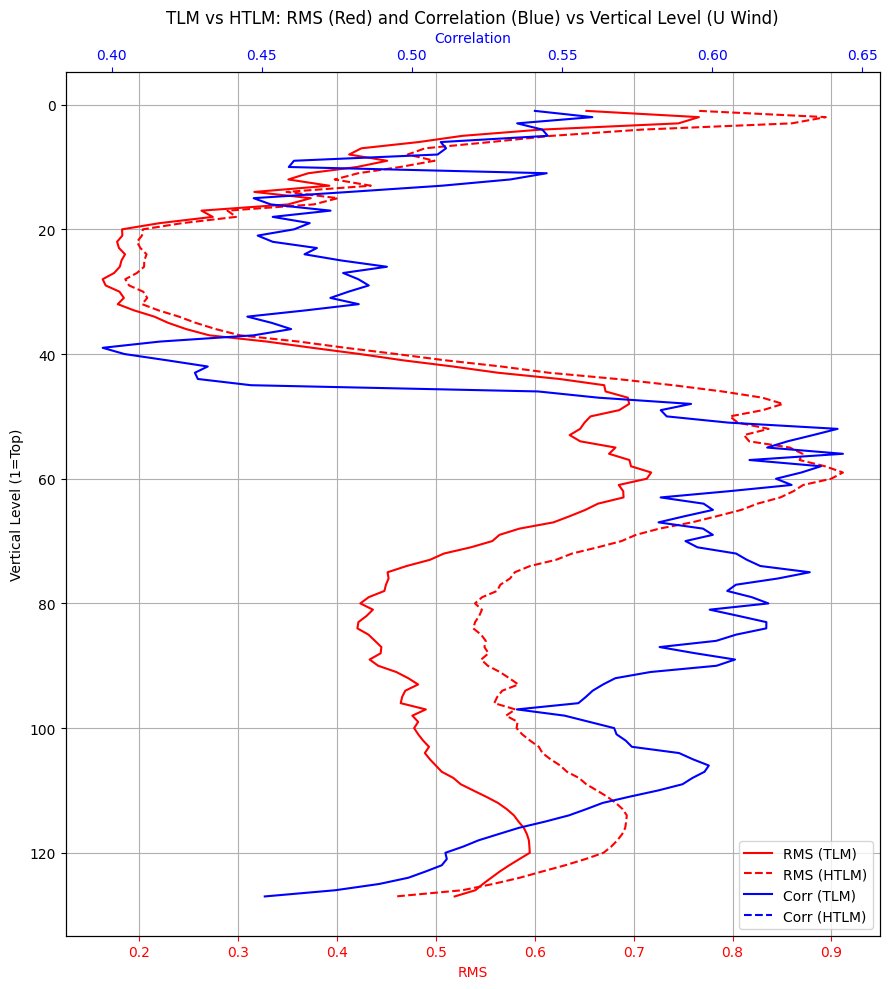

In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# File paths
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2.nc'
file_control = '//Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf009.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

# Load datasets
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_control = xr.open_dataset(file_control)
ds_truth = xr.open_dataset(file_truth)

# Replace pfull coordinates with those from truth for alignment
ds_tlm = ds_tlm.assign_coords(pfull=ds_truth['pfull'])
ds_htlm = ds_htlm.assign_coords(pfull=ds_truth['pfull'])
ds_control = ds_control.assign_coords(pfull=ds_truth['pfull'])

# Extract U wind component and convert to float64
ugrd_tlm = ds_tlm['ugrd'].astype(np.float64).isel(time=0)            # TLM is already differenced
ugrd_htlm = ds_htlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_ctrl = ds_control['ugrd'].astype(np.float64).isel(time=0)
ugrd_truth = ds_truth['ugrd'].astype(np.float64).isel(time=0)

# Compute HTLM - CONTROL
ugrd_htlm_delta = ugrd_htlm - ugrd_ctrl

# Sanity check
assert ugrd_tlm.shape == ugrd_htlm_delta.shape == ugrd_truth.shape, "Mismatch in shapes!"

# Compute RMS and correlation vs truth
rms_tlm = np.sqrt(((ugrd_tlm - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_tlm = xr.corr(ugrd_tlm, ugrd_truth, dim=('grid_yt', 'grid_xt'))

rms_htlm = np.sqrt(((ugrd_htlm_delta - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_htlm = xr.corr(ugrd_htlm_delta, ugrd_truth, dim=('grid_yt', 'grid_xt'))

# Average over the 6 tiles
rms_tlm_mean = rms_tlm.mean(dim='tile')
corr_tlm_mean = corr_tlm.mean(dim='tile')

rms_htlm_mean = rms_htlm.mean(dim='tile')
corr_htlm_mean = corr_htlm.mean(dim='tile')

# Generate vertical levels (1 = top)
levels = np.arange(1, len(rms_tlm['pfull']) + 1)

# Plotting
fig, ax1 = plt.subplots(figsize=(9, 10))

# RMS on primary x-axis (red)
ax1.plot(rms_tlm_mean, levels, 'r-', label='RMS (TLM)')
ax1.plot(rms_htlm_mean, levels, 'r--', label='RMS (HTLM)')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Correlation on secondary x-axis (blue)
ax2 = ax1.twiny()
ax2.plot(corr_tlm_mean, levels, 'b-', label='Corr (TLM)')
ax2.plot(corr_htlm_mean, levels, 'b--', label='Corr (HTLM)')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

# Final touches
plt.title('TLM vs HTLM: RMS (Red) and Correlation (Blue) vs Vertical Level (U Wind)')
plt.tight_layout()
plt.show()

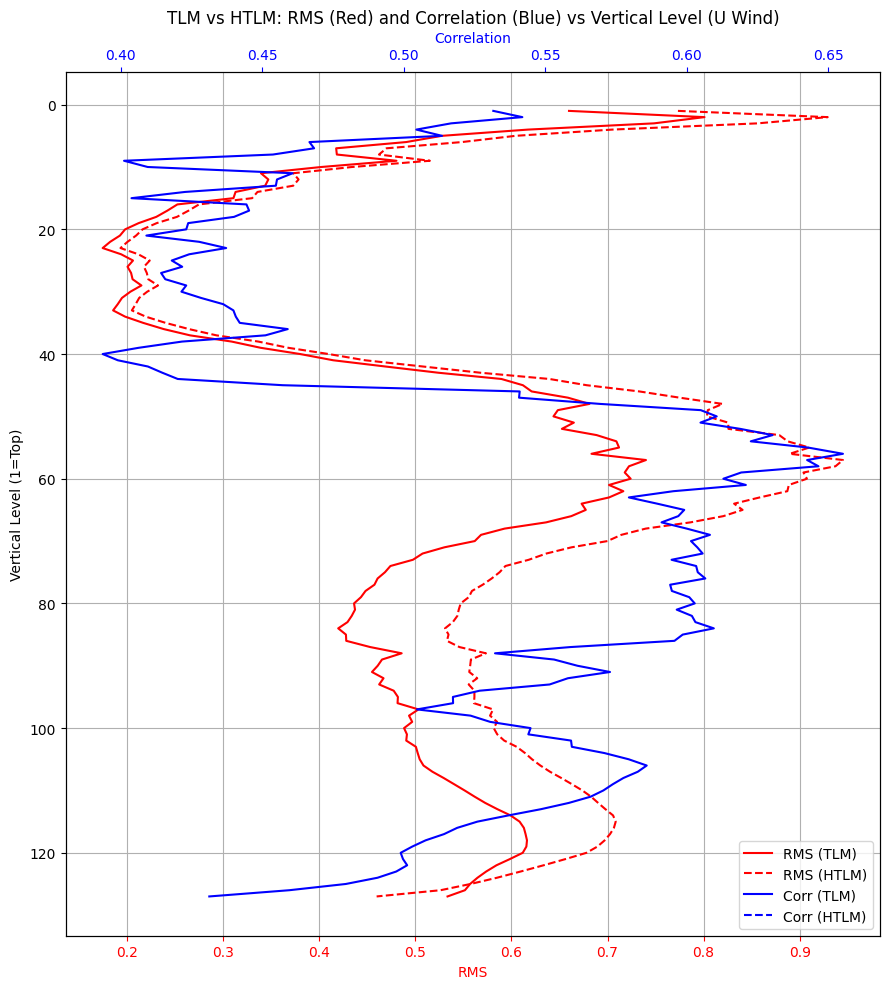

In [21]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# File paths
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem3.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem3_5_lvl.nc'
file_control = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf009.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem003_cubed_sphere_grid_atmf009.nc'

# Load datasets
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_control = xr.open_dataset(file_control)
ds_truth = xr.open_dataset(file_truth)

# Replace pfull coordinates with those from truth for alignment
ds_tlm = ds_tlm.assign_coords(pfull=ds_truth['pfull'])
ds_htlm = ds_htlm.assign_coords(pfull=ds_truth['pfull'])
ds_control = ds_control.assign_coords(pfull=ds_truth['pfull'])

# Extract U wind component and convert to float64
ugrd_tlm = ds_tlm['ugrd'].astype(np.float64).isel(time=0)            # TLM is already differenced
ugrd_htlm = ds_htlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_ctrl = ds_control['ugrd'].astype(np.float64).isel(time=0)
ugrd_truth = ds_truth['ugrd'].astype(np.float64).isel(time=0)

# Compute HTLM - CONTROL
ugrd_htlm_delta = ugrd_htlm - ugrd_ctrl

# Sanity check
assert ugrd_tlm.shape == ugrd_htlm_delta.shape == ugrd_truth.shape, "Mismatch in shapes!"

# Compute RMS and correlation vs truth
rms_tlm = np.sqrt(((ugrd_tlm - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_tlm = xr.corr(ugrd_tlm, ugrd_truth, dim=('grid_yt', 'grid_xt'))

rms_htlm = np.sqrt(((ugrd_htlm_delta - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_htlm = xr.corr(ugrd_htlm_delta, ugrd_truth, dim=('grid_yt', 'grid_xt'))

# Average over the 6 tiles
rms_tlm_mean = rms_tlm.mean(dim='tile')
corr_tlm_mean = corr_tlm.mean(dim='tile')

rms_htlm_mean = rms_htlm.mean(dim='tile')
corr_htlm_mean = corr_htlm.mean(dim='tile')

# Generate vertical levels (1 = top)
levels = np.arange(1, len(rms_tlm['pfull']) + 1)

# Plotting
fig, ax1 = plt.subplots(figsize=(9, 10))

# RMS on primary x-axis (red)
ax1.plot(rms_tlm_mean, levels, 'r-', label='RMS (TLM)')
ax1.plot(rms_htlm_mean, levels, 'r--', label='RMS (HTLM)')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True)

# Correlation on secondary x-axis (blue)
ax2 = ax1.twiny()
ax2.plot(corr_tlm_mean, levels, 'b-', label='Corr (TLM)')
ax2.plot(corr_htlm_mean, levels, 'b--', label='Corr (HTLM)')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

# Final touches
plt.title('TLM vs HTLM: RMS (Red) and Correlation (Blue) vs Vertical Level (U Wind)')
plt.tight_layout()
plt.show()

=== DEBUGGING INFORMATION ===
TLM shape: (6, 127, 48, 48)
HTLM delta shape: (6, 127, 48, 48)
Truth shape: (6, 127, 48, 48)

TLM - NaN count: 0
TLM - Inf count: 0
TLM - Min/Max: -1.005480e+01 / 6.856554e+00

HTLM delta - NaN count: 0
HTLM delta - Inf count: 0
HTLM delta - Min/Max: 0.000000e+00 / 0.000000e+00

Truth - NaN count: 0
Truth - Inf count: 0
Truth - Min/Max: -2.601397e+01 / 1.787753e+01

Variance check:
TLM variance - Min: 1.986330e-03, Max: 6.120309e-01
HTLM variance - Min: 0.000000e+00, Max: 0.000000e+00
Truth variance - Min: 8.364011e-03, Max: 1.933354e+00

Zero variance levels:
TLM: 0, HTLM: 762, Truth: 0

Correlation results:
TLM correlation - NaN count: 0
HTLM correlation - NaN count: 762

Final averaged correlations:
TLM correlation range: 0.397 to 0.644
HTLM correlation range: nan to nan


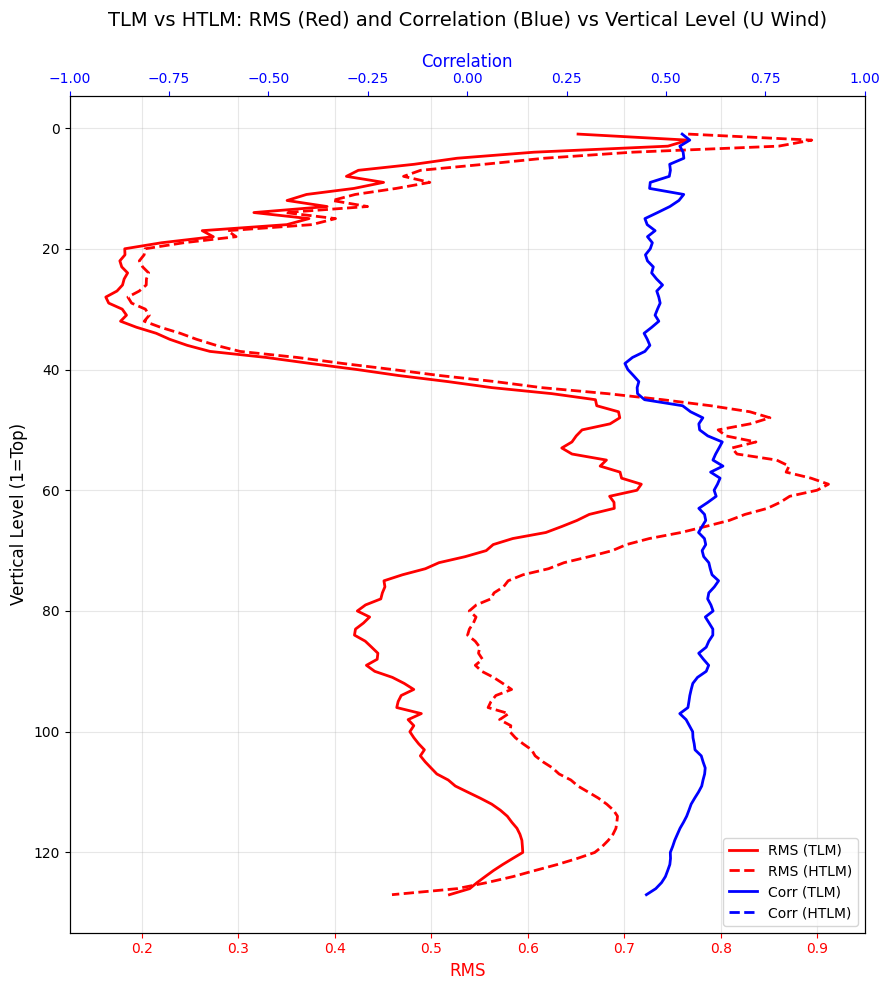


=== LEVEL-BY-LEVEL DIAGNOSTICS ===
Level  1: TLM_corr= 0.541, HTLM_corr=   nan, TLM_rms=6.521e-01, HTLM_rms=7.662e-01
Level  2: TLM_corr= 0.560, HTLM_corr=   nan, TLM_rms=7.659e-01, HTLM_rms=8.943e-01
Level  3: TLM_corr= 0.535, HTLM_corr=   nan, TLM_rms=7.453e-01, HTLM_rms=8.599e-01
Level  4: TLM_corr= 0.543, HTLM_corr=   nan, TLM_rms=6.063e-01, HTLM_rms=7.084e-01
Level  5: TLM_corr= 0.545, HTLM_corr=   nan, TLM_rms=5.268e-01, HTLM_rms=6.171e-01
Level  6: TLM_corr= 0.510, HTLM_corr=   nan, TLM_rms=4.824e-01, HTLM_rms=5.549e-01
Level  7: TLM_corr= 0.511, HTLM_corr=   nan, TLM_rms=4.245e-01, HTLM_rms=4.890e-01
Level  8: TLM_corr= 0.509, HTLM_corr=   nan, TLM_rms=4.121e-01, HTLM_rms=4.713e-01
Level  9: TLM_corr= 0.461, HTLM_corr=   nan, TLM_rms=4.506e-01, HTLM_rms=4.985e-01
Level 10: TLM_corr= 0.459, HTLM_corr=   nan, TLM_rms=4.199e-01, HTLM_rms=4.636e-01
Level 11: TLM_corr= 0.545, HTLM_corr=   nan, TLM_rms=3.707e-01, HTLM_rms=4.213e-01
Level 12: TLM_corr= 0.533, HTLM_corr=   nan, TLM_rm

In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# File paths
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2.nc'
file_control = '//Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf009.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

# Load datasets
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_control = xr.open_dataset(file_control)
ds_truth = xr.open_dataset(file_truth)

# Replace pfull coordinates with those from truth for alignment
ds_tlm = ds_tlm.assign_coords(pfull=ds_truth['pfull'])
ds_htlm = ds_htlm.assign_coords(pfull=ds_truth['pfull'])
ds_control = ds_control.assign_coords(pfull=ds_truth['pfull'])

# Extract U wind component and convert to float64
ugrd_tlm = ds_tlm['ugrd'].astype(np.float64).isel(time=0)  # TLM is already differenced
ugrd_htlm = ds_htlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_ctrl = ds_control['ugrd'].astype(np.float64).isel(time=0)
ugrd_truth = ds_truth['ugrd'].astype(np.float64).isel(time=0)

# Compute HTLM - CONTROL
ugrd_htlm_delta = ugrd_htlm - ugrd_ctrl

print("=== DEBUGGING INFORMATION ===")
print(f"TLM shape: {ugrd_tlm.shape}")
print(f"HTLM delta shape: {ugrd_htlm_delta.shape}")
print(f"Truth shape: {ugrd_truth.shape}")

# Check for NaN or infinite values
print(f"\nTLM - NaN count: {np.isnan(ugrd_tlm).sum().values}")
print(f"TLM - Inf count: {np.isinf(ugrd_tlm).sum().values}")
print(f"TLM - Min/Max: {ugrd_tlm.min().values:.6e} / {ugrd_tlm.max().values:.6e}")

print(f"\nHTLM delta - NaN count: {np.isnan(ugrd_htlm_delta).sum().values}")
print(f"HTLM delta - Inf count: {np.isinf(ugrd_htlm_delta).sum().values}")
print(f"HTLM delta - Min/Max: {ugrd_htlm_delta.min().values:.6e} / {ugrd_htlm_delta.max().values:.6e}")

print(f"\nTruth - NaN count: {np.isnan(ugrd_truth).sum().values}")
print(f"Truth - Inf count: {np.isinf(ugrd_truth).sum().values}")
print(f"Truth - Min/Max: {ugrd_truth.min().values:.6e} / {ugrd_truth.max().values:.6e}")

# Check variance (zero variance causes NaN correlations)
tlm_var = ugrd_tlm.var(dim=('grid_yt', 'grid_xt'))
htlm_var = ugrd_htlm_delta.var(dim=('grid_yt', 'grid_xt'))
truth_var = ugrd_truth.var(dim=('grid_yt', 'grid_xt'))

print(f"\nVariance check:")
print(f"TLM variance - Min: {tlm_var.min().values:.6e}, Max: {tlm_var.max().values:.6e}")
print(f"HTLM variance - Min: {htlm_var.min().values:.6e}, Max: {htlm_var.max().values:.6e}")
print(f"Truth variance - Min: {truth_var.min().values:.6e}, Max: {truth_var.max().values:.6e}")

# Check for zero variance levels (which cause NaN correlations)
zero_var_tlm = (tlm_var == 0).sum().values
zero_var_htlm = (htlm_var == 0).sum().values
zero_var_truth = (truth_var == 0).sum().values

print(f"\nZero variance levels:")
print(f"TLM: {zero_var_tlm}, HTLM: {zero_var_htlm}, Truth: {zero_var_truth}")

# Sanity check
assert ugrd_tlm.shape == ugrd_htlm_delta.shape == ugrd_truth.shape, "Mismatch in shapes!"

# Clean the data by removing NaN and infinite values before correlation
def clean_data(x, y):
    """Remove NaN and infinite values from paired data"""
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    return x.where(mask), y.where(mask)

# Compute correlations with cleaned data
def safe_correlation(x, y, dim):
    """Compute correlation handling NaN/inf values"""
    # Clean the data
    x_clean, y_clean = clean_data(x, y)
    
    # Check if there's enough valid data
    valid_points = (~np.isnan(x_clean) & ~np.isnan(y_clean)).sum(dim=dim)
    
    # Only compute correlation where we have enough valid points
    corr = xr.corr(x_clean, y_clean, dim=dim)
    
    # Set correlation to NaN where we don't have enough valid data
    corr = corr.where(valid_points >= 10)  # Need at least 10 valid points
    
    return corr

# Compute RMS and correlation vs truth
rms_tlm = np.sqrt(((ugrd_tlm - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_tlm = safe_correlation(ugrd_tlm, ugrd_truth, dim=('grid_yt', 'grid_xt'))

rms_htlm = np.sqrt(((ugrd_htlm_delta - ugrd_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_htlm = safe_correlation(ugrd_htlm_delta, ugrd_truth, dim=('grid_yt', 'grid_xt'))

print(f"\nCorrelation results:")
print(f"TLM correlation - NaN count: {np.isnan(corr_tlm).sum().values}")
print(f"HTLM correlation - NaN count: {np.isnan(corr_htlm).sum().values}")

# Average over the 6 tiles (skip NaN values)
rms_tlm_mean = rms_tlm.mean(dim='tile')
corr_tlm_mean = corr_tlm.mean(dim='tile')
rms_htlm_mean = rms_htlm.mean(dim='tile')
corr_htlm_mean = corr_htlm.mean(dim='tile')

print(f"\nFinal averaged correlations:")
print(f"TLM correlation range: {corr_tlm_mean.min().values:.3f} to {corr_tlm_mean.max().values:.3f}")
print(f"HTLM correlation range: {corr_htlm_mean.min().values:.3f} to {corr_htlm_mean.max().values:.3f}")

# Generate vertical levels (1 = top)
levels = np.arange(1, len(rms_tlm['pfull']) + 1)

# Plotting
fig, ax1 = plt.subplots(figsize=(9, 10))

# RMS on primary x-axis (red)
ax1.plot(rms_tlm_mean, levels, 'r-', label='RMS (TLM)', linewidth=2)
ax1.plot(rms_htlm_mean, levels, 'r--', label='RMS (HTLM)', linewidth=2)
ax1.set_xlabel('RMS', color='red', fontsize=12)
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)', fontsize=12)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

# Correlation on secondary x-axis (blue)
ax2 = ax1.twiny()
ax2.plot(corr_tlm_mean, levels, 'b-', label='Corr (TLM)', linewidth=2)
ax2.plot(corr_htlm_mean, levels, 'b--', label='Corr (HTLM)', linewidth=2)
ax2.set_xlabel('Correlation', color='blue', fontsize=12)
ax2.tick_params(axis='x', colors='blue')
ax2.set_xlim(-1, 1)  # Fix correlation axis range

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=10)

# Final touches
plt.title('TLM vs HTLM: RMS (Red) and Correlation (Blue) vs Vertical Level (U Wind)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Additional diagnostic: show level-by-level statistics
print(f"\n=== LEVEL-BY-LEVEL DIAGNOSTICS ===")
for i, level in enumerate(levels):
    tlm_corr_val = corr_tlm_mean.isel(pfull=i).values
    htlm_corr_val = corr_htlm_mean.isel(pfull=i).values
    tlm_rms_val = rms_tlm_mean.isel(pfull=i).values
    htlm_rms_val = rms_htlm_mean.isel(pfull=i).values
    
    print(f"Level {level:2d}: TLM_corr={tlm_corr_val:6.3f}, HTLM_corr={htlm_corr_val:6.3f}, "
          f"TLM_rms={tlm_rms_val:.3e}, HTLM_rms={htlm_rms_val:.3e}")

=== FILE INVESTIGATION ===
TLM file: /Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc
HTLM file: /Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2.nc
Control file: //Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf009.nc
Truth file: /Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc

=== DATASET INFORMATION ===
TLM variables: ['time_iso', 'ugrd', 'vgrd', 'tmp', 'dpres', 'spfh', 'icmr', 'clwmr', 'o3mr']
HTLM variables: ['time_iso', 'ugrd', 'vgrd', 'tmp', 'dpres', 'spfh']
Control variables: ['time_iso', 'clwmr', 'delz', 'dpres', 'dzdt', 'grle', 'hgtsfc', 'icmr', 'nccice', 'nconrd', 'o3mr', 'omga', 'pressfc', 'rwmr', 'snmr', 'spfh', 'tmp', 'ugrd', 'vgrd']
Truth variables: ['time_iso', 'clwmr', 'delz', 'dpres', 'dzdt', 'grle', 'hgtsfc', 'icmr', 'nccice', 'nconrd', 'o3mr', 'omga', 'pressfc

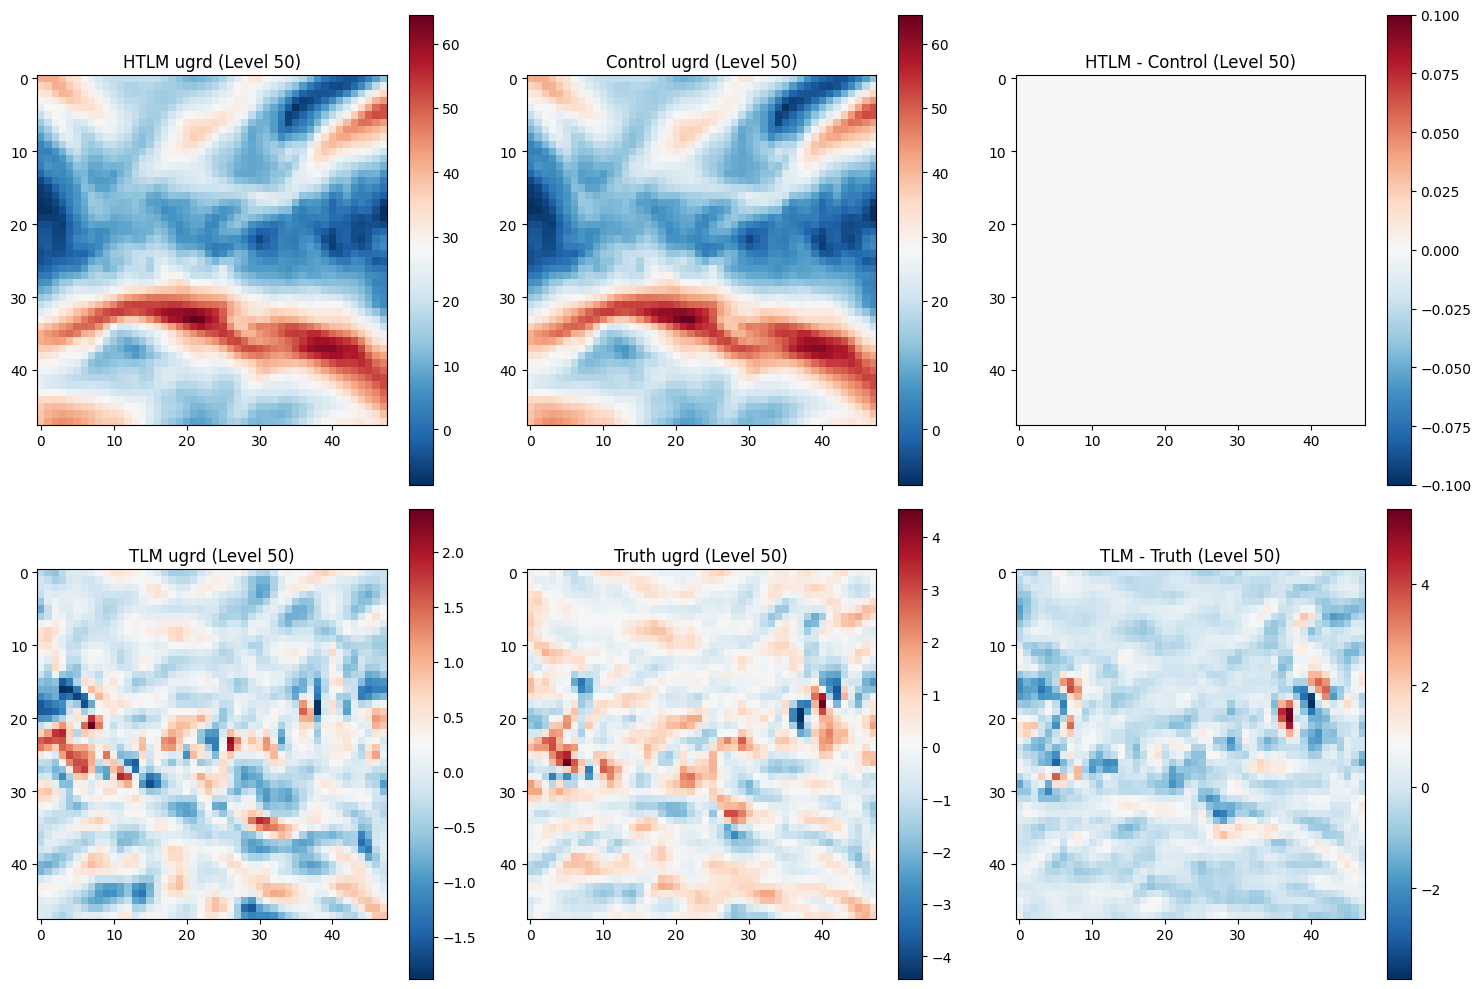


=== RECOMMENDATIONS ===
PROBLEM IDENTIFIED: HTLM and Control files contain identical data!

Possible causes:
1. Wrong file paths - check that you're using the correct HTLM forecast file
2. HTLM training/generation failed - HTLM might have defaulted to control forecast
3. Wrong ensemble member - make sure mem2 HTLM corresponds to the right member
4. File corruption or incomplete processing

Suggested fixes:
1. Verify the HTLM file path and check if it's the intended forecast
2. Check HTLM generation logs for errors
3. Try a different ensemble member or time step
4. Regenerate the HTLM forecast if possible


In [23]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# File paths
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2.nc'
file_control = '//Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf009.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

print("=== FILE INVESTIGATION ===")
print(f"TLM file: {file_tlm}")
print(f"HTLM file: {file_htlm}")
print(f"Control file: {file_control}")
print(f"Truth file: {file_truth}")

# Load datasets
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_control = xr.open_dataset(file_control)
ds_truth = xr.open_dataset(file_truth)

print(f"\n=== DATASET INFORMATION ===")
print(f"TLM variables: {list(ds_tlm.data_vars.keys())}")
print(f"HTLM variables: {list(ds_htlm.data_vars.keys())}")
print(f"Control variables: {list(ds_control.data_vars.keys())}")
print(f"Truth variables: {list(ds_truth.data_vars.keys())}")

# Check if files are identical by comparing file sizes and some metadata
import os
print(f"\n=== FILE SIZES ===")
if os.path.exists(file_htlm.replace('//', '/')):
    print(f"HTLM size: {os.path.getsize(file_htlm.replace('//', '/')) / 1e6:.2f} MB")
if os.path.exists(file_control.replace('//', '/')):
    print(f"Control size: {os.path.getsize(file_control.replace('//', '/')) / 1e6:.2f} MB")

# Replace pfull coordinates for alignment
ds_tlm = ds_tlm.assign_coords(pfull=ds_truth['pfull'])
ds_htlm = ds_htlm.assign_coords(pfull=ds_truth['pfull'])
ds_control = ds_control.assign_coords(pfull=ds_truth['pfull'])

# Extract data
ugrd_tlm = ds_tlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_htlm = ds_htlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_ctrl = ds_control['ugrd'].astype(np.float64).isel(time=0)
ugrd_truth = ds_truth['ugrd'].astype(np.float64).isel(time=0)

print(f"\n=== DETAILED DATA COMPARISON ===")
print(f"HTLM ugrd stats: min={ugrd_htlm.min().values:.6e}, max={ugrd_htlm.max().values:.6e}, mean={ugrd_htlm.mean().values:.6e}")
print(f"Control ugrd stats: min={ugrd_ctrl.min().values:.6e}, max={ugrd_ctrl.max().values:.6e}, mean={ugrd_ctrl.mean().values:.6e}")

# Check if arrays are exactly identical
arrays_identical = np.array_equal(ugrd_htlm.values, ugrd_ctrl.values)
print(f"HTLM and Control arrays are identical: {arrays_identical}")

# Check absolute difference
abs_diff = np.abs(ugrd_htlm - ugrd_ctrl)
print(f"Absolute difference stats: min={abs_diff.min().values:.6e}, max={abs_diff.max().values:.6e}, mean={abs_diff.mean().values:.6e}")

# Check if they're identical to machine precision
max_abs_diff = abs_diff.max().values
print(f"Maximum absolute difference: {max_abs_diff:.6e}")
print(f"Identical to machine precision: {max_abs_diff < 1e-15}")

# Let's also check other variables to see if this is a systematic issue
print(f"\n=== CHECKING OTHER VARIABLES ===")
for var in ['vgrd', 'tmp', 'delp']:  # Common atmospheric variables
    if var in ds_htlm.data_vars and var in ds_control.data_vars:
        htlm_var = ds_htlm[var].astype(np.float64).isel(time=0)
        ctrl_var = ds_control[var].astype(np.float64).isel(time=0)
        
        var_identical = np.array_equal(htlm_var.values, ctrl_var.values)
        var_diff = np.abs(htlm_var - ctrl_var).max().values
        
        print(f"{var}: identical={var_identical}, max_diff={var_diff:.6e}")

# Plot comparison of a single level to visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
level_to_plot = 50  # Mid-troposphere
tile_to_plot = 0

# Plot HTLM
im1 = axes[0, 0].imshow(ugrd_htlm.isel(tile=tile_to_plot, pfull=level_to_plot), cmap='RdBu_r')
axes[0, 0].set_title(f'HTLM ugrd (Level {level_to_plot})')
plt.colorbar(im1, ax=axes[0, 0])

# Plot Control
im2 = axes[0, 1].imshow(ugrd_ctrl.isel(tile=tile_to_plot, pfull=level_to_plot), cmap='RdBu_r')
axes[0, 1].set_title(f'Control ugrd (Level {level_to_plot})')
plt.colorbar(im2, ax=axes[0, 1])

# Plot difference (should be zeros)
diff = ugrd_htlm.isel(tile=tile_to_plot, pfull=level_to_plot) - ugrd_ctrl.isel(tile=tile_to_plot, pfull=level_to_plot)
im3 = axes[0, 2].imshow(diff, cmap='RdBu_r')
axes[0, 2].set_title(f'HTLM - Control (Level {level_to_plot})')
plt.colorbar(im3, ax=axes[0, 2])

# Plot TLM for reference
im4 = axes[1, 0].imshow(ugrd_tlm.isel(tile=tile_to_plot, pfull=level_to_plot), cmap='RdBu_r')
axes[1, 0].set_title(f'TLM ugrd (Level {level_to_plot})')
plt.colorbar(im4, ax=axes[1, 0])

# Plot Truth for reference
im5 = axes[1, 1].imshow(ugrd_truth.isel(tile=tile_to_plot, pfull=level_to_plot), cmap='RdBu_r')
axes[1, 1].set_title(f'Truth ugrd (Level {level_to_plot})')
plt.colorbar(im5, ax=axes[1, 1])

# Plot TLM vs Truth for reference
im6 = axes[1, 2].imshow(ugrd_tlm.isel(tile=tile_to_plot, pfull=level_to_plot) - ugrd_truth.isel(tile=tile_to_plot, pfull=level_to_plot), cmap='RdBu_r')
axes[1, 2].set_title(f'TLM - Truth (Level {level_to_plot})')
plt.colorbar(im6, ax=axes[1, 2])

plt.tight_layout()
plt.show()

print(f"\n=== RECOMMENDATIONS ===")
if arrays_identical:
    print("PROBLEM IDENTIFIED: HTLM and Control files contain identical data!")
    print("\nPossible causes:")
    print("1. Wrong file paths - check that you're using the correct HTLM forecast file")
    print("2. HTLM training/generation failed - HTLM might have defaulted to control forecast")
    print("3. Wrong ensemble member - make sure mem2 HTLM corresponds to the right member")
    print("4. File corruption or incomplete processing")
    print("\nSuggested fixes:")
    print("1. Verify the HTLM file path and check if it's the intended forecast")
    print("2. Check HTLM generation logs for errors")
    print("3. Try a different ensemble member or time step")
    print("4. Regenerate the HTLM forecast if possible")
else:
    print("Files are not identical but difference is very small")
    print("This might be due to numerical precision issues")

=== LOADING DATA ===
=== COMPUTING PERTURBATIONS ===
TLM perturbation stats: min=-1.005480e+01, max=6.856554e+00
HTLM perturbation stats: min=-8.266830e+01, max=9.461350e+01
Truth perturbation stats: min=-2.601397e+01, max=1.787753e+01

=== DATA QUALITY CHECK ===
TLM - NaN count: 0, Inf count: 0
HTLM - NaN count: 0, Inf count: 0
Truth - NaN count: 0, Inf count: 0

Variance by level (should be > 0):
TLM: 4.817660e-03 to 2.822083e-01
HTLM: 3.348212e+00 to 5.896235e+02
Truth: 3.737786e-02 to 8.510938e-01
Zero variance levels: TLM=0, HTLM=0, Truth=0

Manual correlation:
TLM correlation range: 0.205 to 0.633
HTLM correlation range: -0.117 to 0.082

=== XARRAY CORRELATION ===
TLM Xarray correlation: 0.205 to 0.633
HTLM Xarray correlation: -0.117 to 0.082

RMS errors:
TLM RMS: 1.721911e-01 to 7.778948e-01
HTLM RMS: 1.932275e+00 to 2.431494e+01


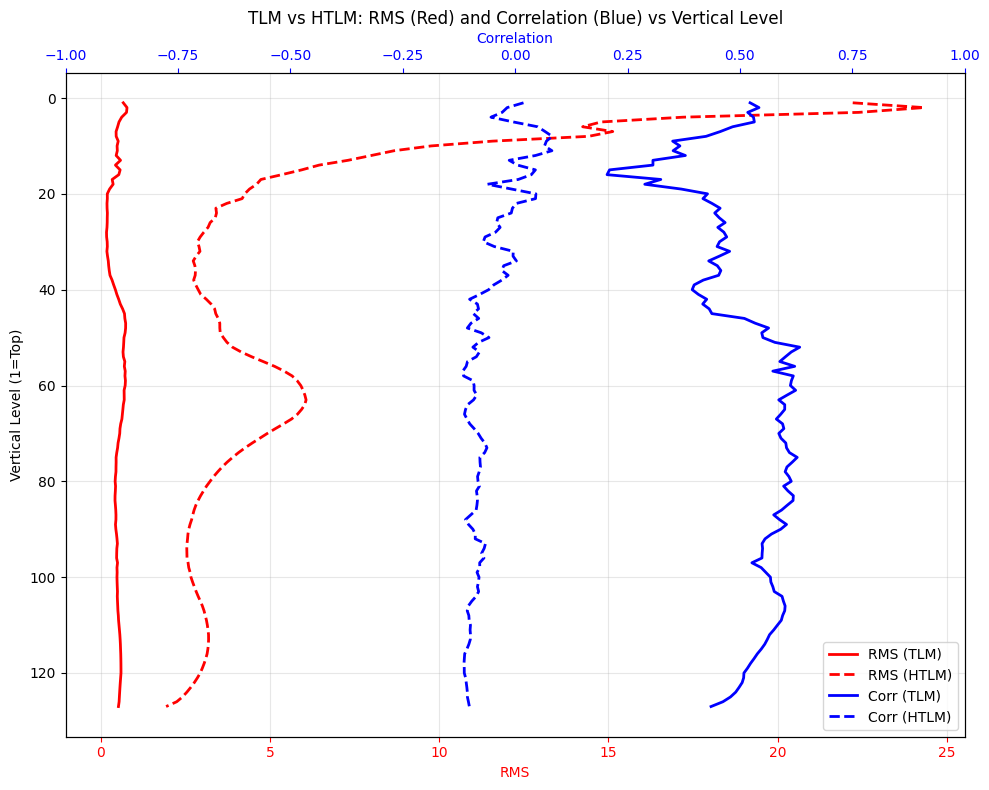


=== SAMPLE VALUES (Level 50) ===
Level 50 - TLM correlation: 0.5512
Level 50 - HTLM correlation: -0.0582
Level 50 - TLM RMS: 6.878975e-01
Level 50 - HTLM RMS: 3.623640e+00


In [30]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# File paths (UPDATED to use mem001 instead of mem002)
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2.nc'
file_control = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

print("=== LOADING DATA ===")
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_control = xr.open_dataset(file_control)
ds_truth = xr.open_dataset(file_truth)

# Ensure alignment
ds_tlm = ds_tlm.assign_coords(pfull=ds_truth['pfull'])
ds_htlm = ds_htlm.assign_coords(pfull=ds_truth['pfull'])
ds_control = ds_control.assign_coords(pfull=ds_truth['pfull'])

# Extract ugrd field
ugrd_tlm = ds_tlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_htlm = ds_htlm['ugrd'].astype(np.float64).isel(time=0)
ugrd_ctrl = ds_control['ugrd'].astype(np.float64).isel(time=0)
ugrd_truth = ds_truth['ugrd'].astype(np.float64).isel(time=0)

print("=== COMPUTING PERTURBATIONS ===")
ugrd_tlm_pert = ugrd_tlm
ugrd_htlm_pert = ugrd_htlm - ugrd_ctrl  # Now using mem001
ugrd_truth_pert = ugrd_truth           # Already diff_mem001

print(f"TLM perturbation stats: min={ugrd_tlm_pert.min().values:.6e}, max={ugrd_tlm_pert.max().values:.6e}")
print(f"HTLM perturbation stats: min={ugrd_htlm_pert.min().values:.6e}, max={ugrd_htlm_pert.max().values:.6e}")
print(f"Truth perturbation stats: min={ugrd_truth_pert.min().values:.6e}, max={ugrd_truth_pert.max().values:.6e}")

# Data quality checks
print(f"\n=== DATA QUALITY CHECK ===")
print(f"TLM - NaN count: {np.isnan(ugrd_tlm_pert).sum().values}, Inf count: {np.isinf(ugrd_tlm_pert).sum().values}")
print(f"HTLM - NaN count: {np.isnan(ugrd_htlm_pert).sum().values}, Inf count: {np.isinf(ugrd_htlm_pert).sum().values}")
print(f"Truth - NaN count: {np.isnan(ugrd_truth_pert).sum().values}, Inf count: {np.isinf(ugrd_truth_pert).sum().values}")

# Variance by level
tlm_var_by_level = ugrd_tlm_pert.var(dim=('tile', 'grid_yt', 'grid_xt'))
htlm_var_by_level = ugrd_htlm_pert.var(dim=('tile', 'grid_yt', 'grid_xt'))
truth_var_by_level = ugrd_truth_pert.var(dim=('tile', 'grid_yt', 'grid_xt'))

print(f"\nVariance by level (should be > 0):")
print(f"TLM: {tlm_var_by_level.min().values:.6e} to {tlm_var_by_level.max().values:.6e}")
print(f"HTLM: {htlm_var_by_level.min().values:.6e} to {htlm_var_by_level.max().values:.6e}")
print(f"Truth: {truth_var_by_level.min().values:.6e} to {truth_var_by_level.max().values:.6e}")

# Count low-variance levels
print(f"Zero variance levels: TLM={(tlm_var_by_level < 1e-15).sum().values}, HTLM={(htlm_var_by_level < 1e-15).sum().values}, Truth={(truth_var_by_level < 1e-15).sum().values}")

# Manual correlation computation
def compute_correlation_by_level(x, y):
    correlations = []
    n_levels = x.shape[1]
    
    for level in range(n_levels):
        x_level = x[:, level, :, :].values.flatten()
        y_level = y[:, level, :, :].values.flatten()
        
        mask = ~(np.isnan(x_level) | np.isnan(y_level) | np.isinf(x_level) | np.isinf(y_level))
        x_clean = x_level[mask]
        y_clean = y_level[mask]
        
        if len(x_clean) < 10 or np.var(x_clean) < 1e-15 or np.var(y_clean) < 1e-15:
            correlations.append(np.nan)
            continue
        
        corr = np.corrcoef(x_clean, y_clean)[0, 1]
        correlations.append(corr)
    
    return np.array(correlations)

corr_tlm_manual = compute_correlation_by_level(ugrd_tlm_pert, ugrd_truth_pert)
corr_htlm_manual = compute_correlation_by_level(ugrd_htlm_pert, ugrd_truth_pert)

print(f"\nManual correlation:")
print(f"TLM correlation range: {np.nanmin(corr_tlm_manual):.3f} to {np.nanmax(corr_tlm_manual):.3f}")
print(f"HTLM correlation range: {np.nanmin(corr_htlm_manual):.3f} to {np.nanmax(corr_htlm_manual):.3f}")

# xarray correlation
print("\n=== XARRAY CORRELATION ===")
corr_tlm_xr = xr.corr(ugrd_tlm_pert, ugrd_truth_pert, dim=('tile', 'grid_yt', 'grid_xt'))
corr_htlm_xr = xr.corr(ugrd_htlm_pert, ugrd_truth_pert, dim=('tile', 'grid_yt', 'grid_xt'))

print(f"TLM Xarray correlation: {corr_tlm_xr.min().values:.3f} to {corr_tlm_xr.max().values:.3f}")
print(f"HTLM Xarray correlation: {corr_htlm_xr.min().values:.3f} to {corr_htlm_xr.max().values:.3f}")

# RMS errors
rms_tlm = np.sqrt(((ugrd_tlm_pert - ugrd_truth_pert) ** 2).mean(dim=('tile', 'grid_yt', 'grid_xt')))
rms_htlm = np.sqrt(((ugrd_htlm_pert - ugrd_truth_pert) ** 2).mean(dim=('tile', 'grid_yt', 'grid_xt')))

print("\nRMS errors:")
print(f"TLM RMS: {rms_tlm.min().values:.6e} to {rms_tlm.max().values:.6e}")
print(f"HTLM RMS: {rms_htlm.min().values:.6e} to {rms_htlm.max().values:.6e}")

# Plot
levels = np.arange(1, len(corr_tlm_manual) + 1)
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.plot(rms_tlm, levels, 'r-', label='RMS (TLM)', linewidth=2)
ax1.plot(rms_htlm, levels, 'r--', label='RMS (HTLM)', linewidth=2)
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1=Top)')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

ax2 = ax1.twiny()
ax2.plot(corr_tlm_manual, levels, 'b-', label='Corr (TLM)', linewidth=2)
ax2.plot(corr_htlm_manual, levels, 'b--', label='Corr (HTLM)', linewidth=2)
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')
ax2.set_xlim(-1, 1)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('TLM vs HTLM: RMS (Red) and Correlation (Blue) vs Vertical Level')
plt.tight_layout()
plt.show()

# Debug print for one level
print("\n=== SAMPLE VALUES (Level 50) ===")
level_idx = 49
print(f"Level 50 - TLM correlation: {corr_tlm_manual[level_idx]:.4f}")
print(f"Level 50 - HTLM correlation: {corr_htlm_manual[level_idx]:.4f}")
print(f"Level 50 - TLM RMS: {rms_tlm.isel(pfull=level_idx).values:.6e}")
print(f"Level 50 - HTLM RMS: {rms_htlm.isel(pfull=level_idx).values:.6e}")

In [5]:
import xarray as xr

# === File paths ===
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2.nc'
file_control = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

# === Load datasets ===
print("=== LOADING DATASETS ===")
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_control = xr.open_dataset(file_control)
ds_truth = xr.open_dataset(file_truth)

# === Exclude these variable names ===
excluded_vars = ['ugrd', 'vgrd', 'tmp']

# === Function to print filtered variable names ===
def print_filtered_vars(ds, ds_name):
    print(f"\nVariables in {ds_name} (excluding {excluded_vars}):")
    filtered = [var for var in ds.variables if var not in excluded_vars]
    for var in filtered:
        print(f" - {var}")

# === Print variables ===
print_filtered_vars(ds_tlm, "TLM")
print_filtered_vars(ds_htlm, "HTLM")
print_filtered_vars(ds_control, "Control")
print_filtered_vars(ds_truth, "Truth")

=== LOADING DATASETS ===

Variables in TLM (excluding ['ugrd', 'vgrd', 'tmp']):
 - tile
 - grid_xt
 - grid_yt
 - lon
 - lat
 - pfull
 - phalf
 - time
 - time_iso
 - dpres
 - spfh
 - icmr
 - clwmr
 - o3mr

Variables in HTLM (excluding ['ugrd', 'vgrd', 'tmp']):
 - tile
 - grid_xt
 - grid_yt
 - lon
 - lat
 - pfull
 - phalf
 - time
 - time_iso
 - dpres
 - spfh

Variables in Control (excluding ['ugrd', 'vgrd', 'tmp']):
 - grid_xt
 - grid_yt
 - pfull
 - phalf
 - time
 - tile
 - time_iso
 - lon
 - lat
 - clwmr
 - delz
 - dpres
 - dzdt
 - grle
 - hgtsfc
 - icmr
 - nccice
 - nconrd
 - o3mr
 - omga
 - pressfc
 - rwmr
 - snmr
 - spfh

Variables in Truth (excluding ['ugrd', 'vgrd', 'tmp']):
 - time
 - time_iso
 - grid_xt
 - grid_yt
 - pfull
 - tile
 - lon
 - lat
 - clwmr
 - delz
 - dpres
 - dzdt
 - grle
 - hgtsfc
 - icmr
 - nccice
 - nconrd
 - o3mr
 - omga
 - pressfc
 - rwmr
 - snmr
 - spfh


In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === File paths ===
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2.nc'
file_control = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

# === Load datasets ===
print("=== LOADING DATASETS ===")
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_control = xr.open_dataset(file_control)
ds_truth = xr.open_dataset(file_truth)

# === Extract lat/lon and pressure variables ===
lat = ds_control['lat'].values
lon = ds_control['lon'].values
pres_tlm = ds_tlm['pres'].squeeze()
pres_htlm = ds_htlm['pres'].squeeze()
pres_truth = ds_truth['pres'].squeeze()

# === Compute MSLP by adding pressure perturbations to control ===
pres_tlm_total = pres_tlm + ds_control['pres'].squeeze()
pres_htlm_total = pres_htlm + ds_control['pres'].squeeze()
pres_truth_total = pres_truth + ds_control['pres'].squeeze()

# === Function to plot MSLP contours ===
def plot_mslp_contours(data, lat, lon, title, outname=None):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(title, fontsize=14)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True)

    # Plot contours
    cs = ax.contour(lon, lat, data, levels=20, colors='black', linewidths=1)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%1.0f')

    if outname:
        plt.savefig(outname, dpi=300, bbox_inches='tight')
    plt.show()

# === Plot all three fields ===
plot_mslp_contours(pres_tlm_total, lat, lon, title='TLM Forecast: MSLP')
plot_mslp_contours(pres_htlm_total, lat, lon, title='HTLM Forecast: MSLP')
plot_mslp_contours(pres_truth_total, lat, lon, title='Truth: MSLP')

=== LOADING DATASETS ===


KeyError: "No variable named 'pres'. Variables on the dataset include ['tile', 'grid_xt', 'grid_yt', 'lon', 'lat', ..., 'dpres', 'spfh', 'icmr', 'clwmr', 'o3mr']"

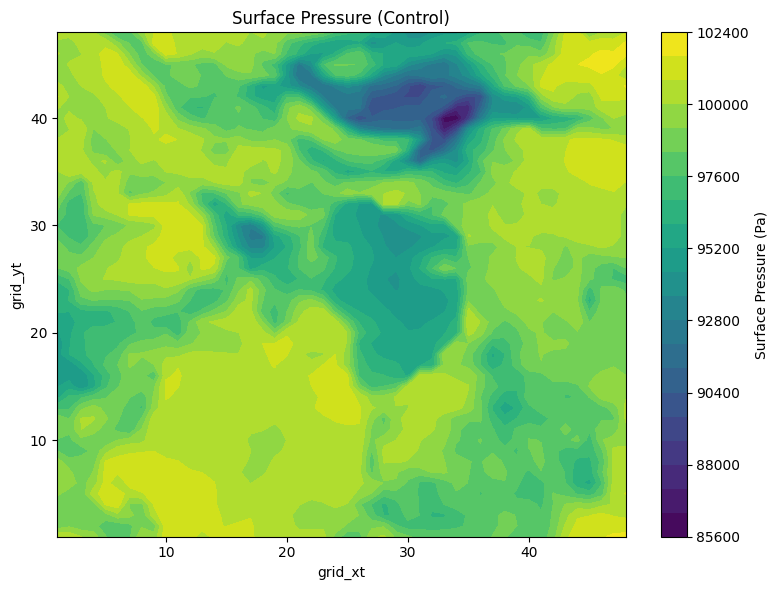

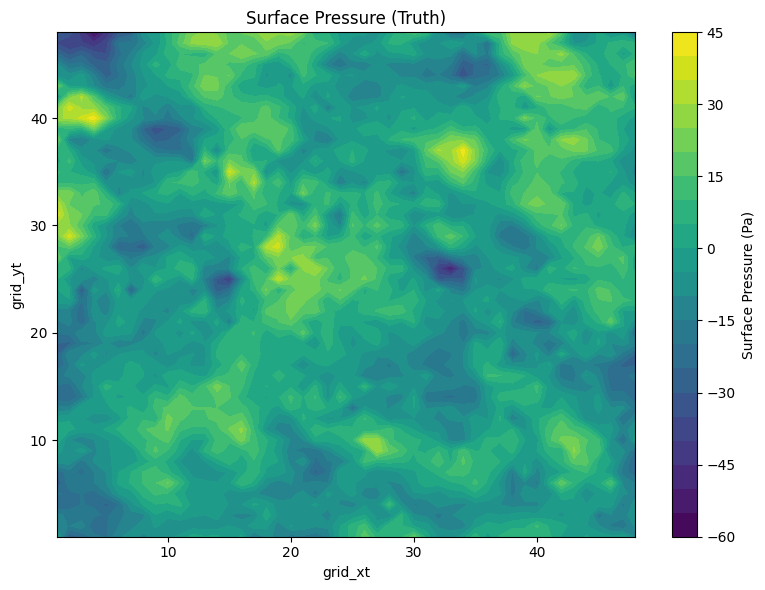

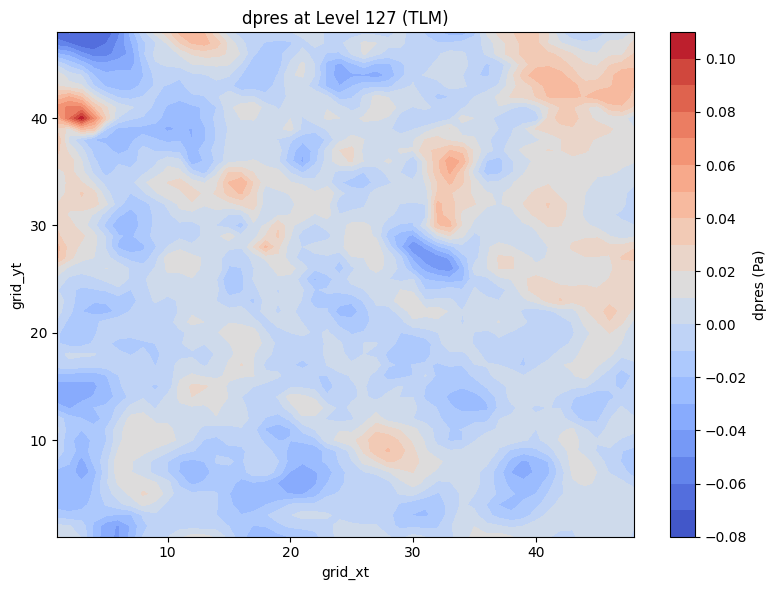

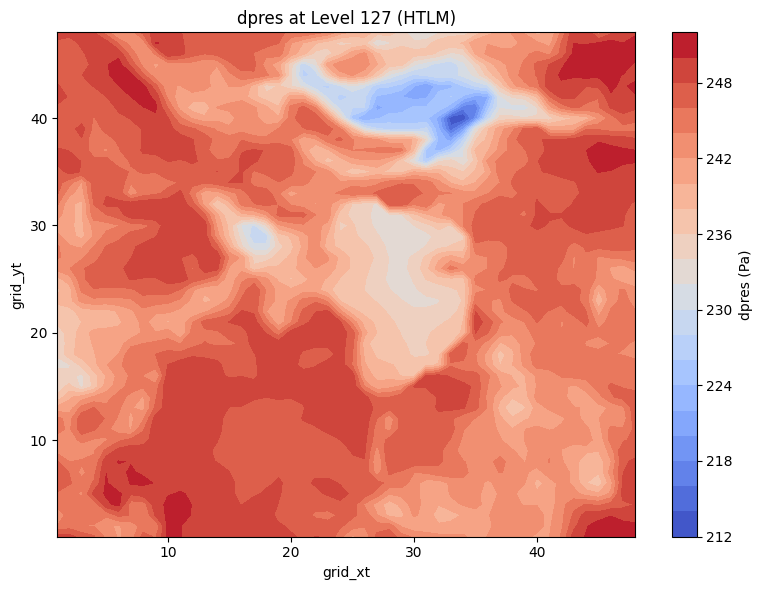

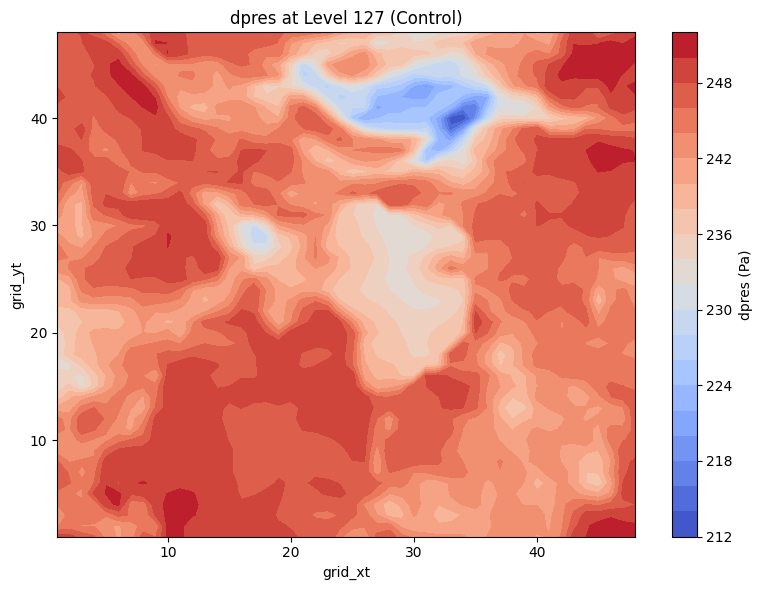

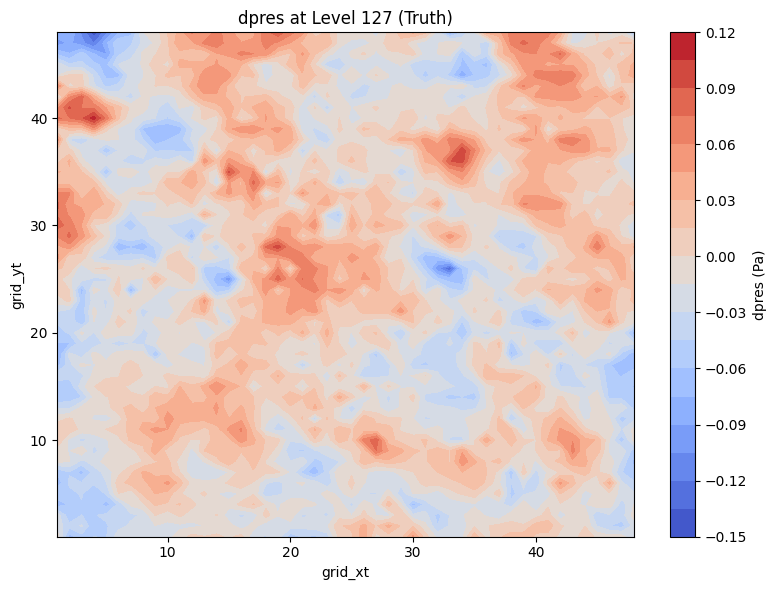

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# === File paths ===
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere1.nc'
file_htlm = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/forecast/htlm_forecast_cubed_sphere_mem2.nc'
file_control = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf009.nc'

# === Load datasets ===
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_control = xr.open_dataset(file_control)
ds_truth = xr.open_dataset(file_truth)

# === Extract surface pressure ===
pressfc_ctrl = ds_control['pressfc'].isel(time=0)
pressfc_truth = ds_truth['pressfc'].isel(time=0)

# === Plot surface pressure (pressfc) ===
def plot_surface_pressure(data, title):
    mean_data = data.mean(dim='tile')  # Average across tiles
    plt.figure(figsize=(8, 6))
    plt.contourf(mean_data['grid_xt'], mean_data['grid_yt'], mean_data, levels=20, cmap='viridis')
    plt.colorbar(label='Surface Pressure (Pa)')
    plt.title(title)
    plt.xlabel('grid_xt')
    plt.ylabel('grid_yt')
    plt.tight_layout()
    plt.show()

plot_surface_pressure(pressfc_ctrl, 'Surface Pressure (Control)')
plot_surface_pressure(pressfc_truth, 'Surface Pressure (Truth)')

# === Extract dpres at near-surface level (e.g., index 49) ===
level_idx = 126  # Adjust depending on vertical coordinate

dpres_tlm = ds_tlm['dpres'].isel(time=0, pfull=level_idx)
dpres_htlm = ds_htlm['dpres'].isel(time=0, pfull=level_idx)
dpres_ctrl = ds_control['dpres'].isel(time=0, pfull=level_idx)
dpres_truth = ds_truth['dpres'].isel(time=0, pfull=level_idx)

# === Plot dpres ===
def plot_dpres(data, title):
    mean_data = data.mean(dim='tile')
    plt.figure(figsize=(8, 6))
    plt.contourf(mean_data['grid_xt'], mean_data['grid_yt'], mean_data, levels=20, cmap='coolwarm')
    plt.colorbar(label='dpres (Pa)')
    plt.title(title)
    plt.xlabel('grid_xt')
    plt.ylabel('grid_yt')
    plt.tight_layout()
    plt.show()

plot_dpres(dpres_tlm, f'dpres at Level {level_idx+1} (TLM)')
plot_dpres(dpres_htlm, f'dpres at Level {level_idx+1} (HTLM)')
plot_dpres(dpres_ctrl, f'dpres at Level {level_idx+1} (Control)')
plot_dpres(dpres_truth, f'dpres at Level {level_idx+1} (Truth)')

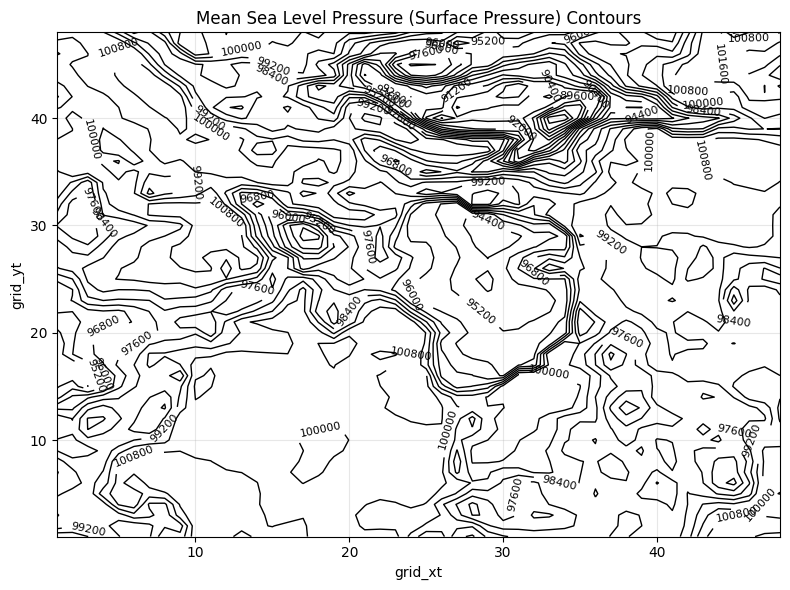

In [7]:
import xarray as xr
import matplotlib.pyplot as plt

# === File paths ===
file_control = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'

# === Load dataset ===
ds_control = xr.open_dataset(file_control)

# === Extract surface pressure (pressfc) ===
pressfc = ds_control['pressfc'].isel(time=0)
mean_pressfc = pressfc.mean(dim='tile')  # Collapse tile dimension

# === Plot surface pressure contours ===
plt.figure(figsize=(8, 6))
contour = plt.contour(mean_pressfc['grid_xt'], mean_pressfc['grid_yt'], mean_pressfc, levels=20, colors='black', linewidths=1)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
plt.title('Mean Sea Level Pressure (Surface Pressure) Contours')
plt.xlabel('grid_xt')
plt.ylabel('grid_yt')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [1]:
import xarray as xr

# Load the control dataset
control_path = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
ds_control = xr.open_dataset(control_path)

# Display all variable names and their dimensions
print("Variables in control dataset:")
for var in ds_control.data_vars:
    print(f" - {var}: {ds_control[var].dims}")

Variables in control dataset:
 - time_iso: ('time',)
 - clwmr: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - delz: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - dpres: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - dzdt: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - grle: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - hgtsfc: ('time', 'tile', 'grid_yt', 'grid_xt')
 - icmr: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - nccice: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - nconrd: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - o3mr: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - omga: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - pressfc: ('time', 'tile', 'grid_yt', 'grid_xt')
 - rwmr: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - snmr: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - spfh: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - tmp: ('time', 'tile', 'pfull', 'grid_yt', 'grid_xt')
 - ugrd: ('time', 'tile', 'pfull', 'grid_yt

/var/folders/_s/w0_bj1693_bg4hxwb34kxqr40000gt/T/ipykernel_39324/3649617986.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  level_index = ds.dims['pfull'] - 30  # near-surface (adjust as needed)


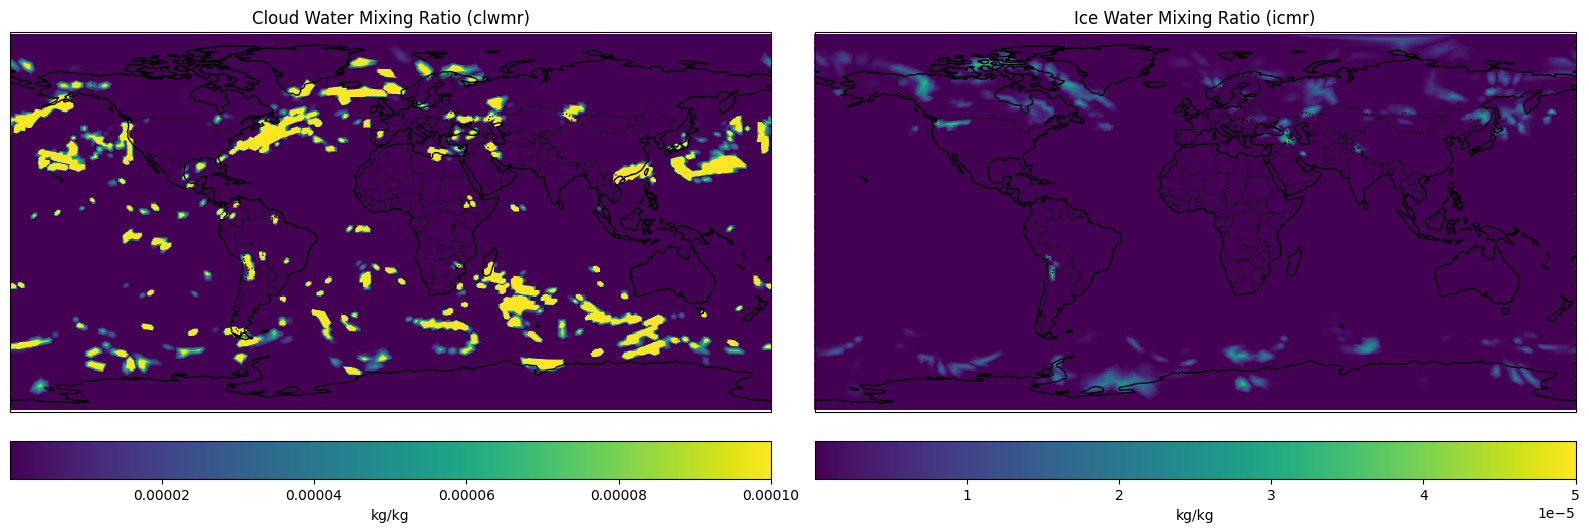

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Load data ---
control_path = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
ds = xr.open_dataset(control_path)

# --- Select time and vertical level ---
time_index = 0
level_index = ds.dims['pfull'] - 30  # near-surface (adjust as needed)

# --- Extract variables from all tiles ---
clwmr = ds['clwmr'].isel(time=time_index, pfull=level_index)
icmr = ds['icmr'].isel(time=time_index, pfull=level_index)
lat = ds['lat']
lon = ds['lon']

# --- Flatten all tiles into 1D ---
clwmr_vals = clwmr.values.reshape(-1)
icmr_vals = icmr.values.reshape(-1)
lat_vals = lat.values.reshape(-1)
lon_vals = lon.values.reshape(-1)

# --- Extend longitudes for global interpolation ---
lon_ext = np.concatenate([lon_vals, lon_vals - 360])
lat_ext = np.concatenate([lat_vals, lat_vals])
clwmr_ext = np.concatenate([clwmr_vals, clwmr_vals])
icmr_ext = np.concatenate([icmr_vals, icmr_vals])

# --- Create regular lat/lon grid ---
lon_grid, lat_grid = np.meshgrid(np.linspace(-180, 180, 720), np.linspace(-90, 90, 361))

# --- Interpolate fields ---
clwmr_interp = griddata((lon_ext, lat_ext), clwmr_ext, (lon_grid, lat_grid), method='linear')
icmr_interp = griddata((lon_ext, lat_ext), icmr_ext, (lon_grid, lat_grid), method='linear')

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()})

for ax, data, title, bounds in zip(
    axs,
    [clwmr_interp, icmr_interp],
    ['Cloud Water Mixing Ratio (clwmr)', 'Ice Water Mixing Ratio (icmr)'],
    [(1e-7, 1e-4), (1e-8, 5e-5)]  # Adjust color scale as needed
):
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    pcm = ax.pcolormesh(
        lon_grid, lat_grid, data,
        transform=ccrs.PlateCarree(),
        shading='auto',
        cmap='viridis',
        vmin=bounds[0],
        vmax=bounds[1]
    )
    ax.set_title(title)
    plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.05, label='kg/kg')

plt.tight_layout()
plt.show()

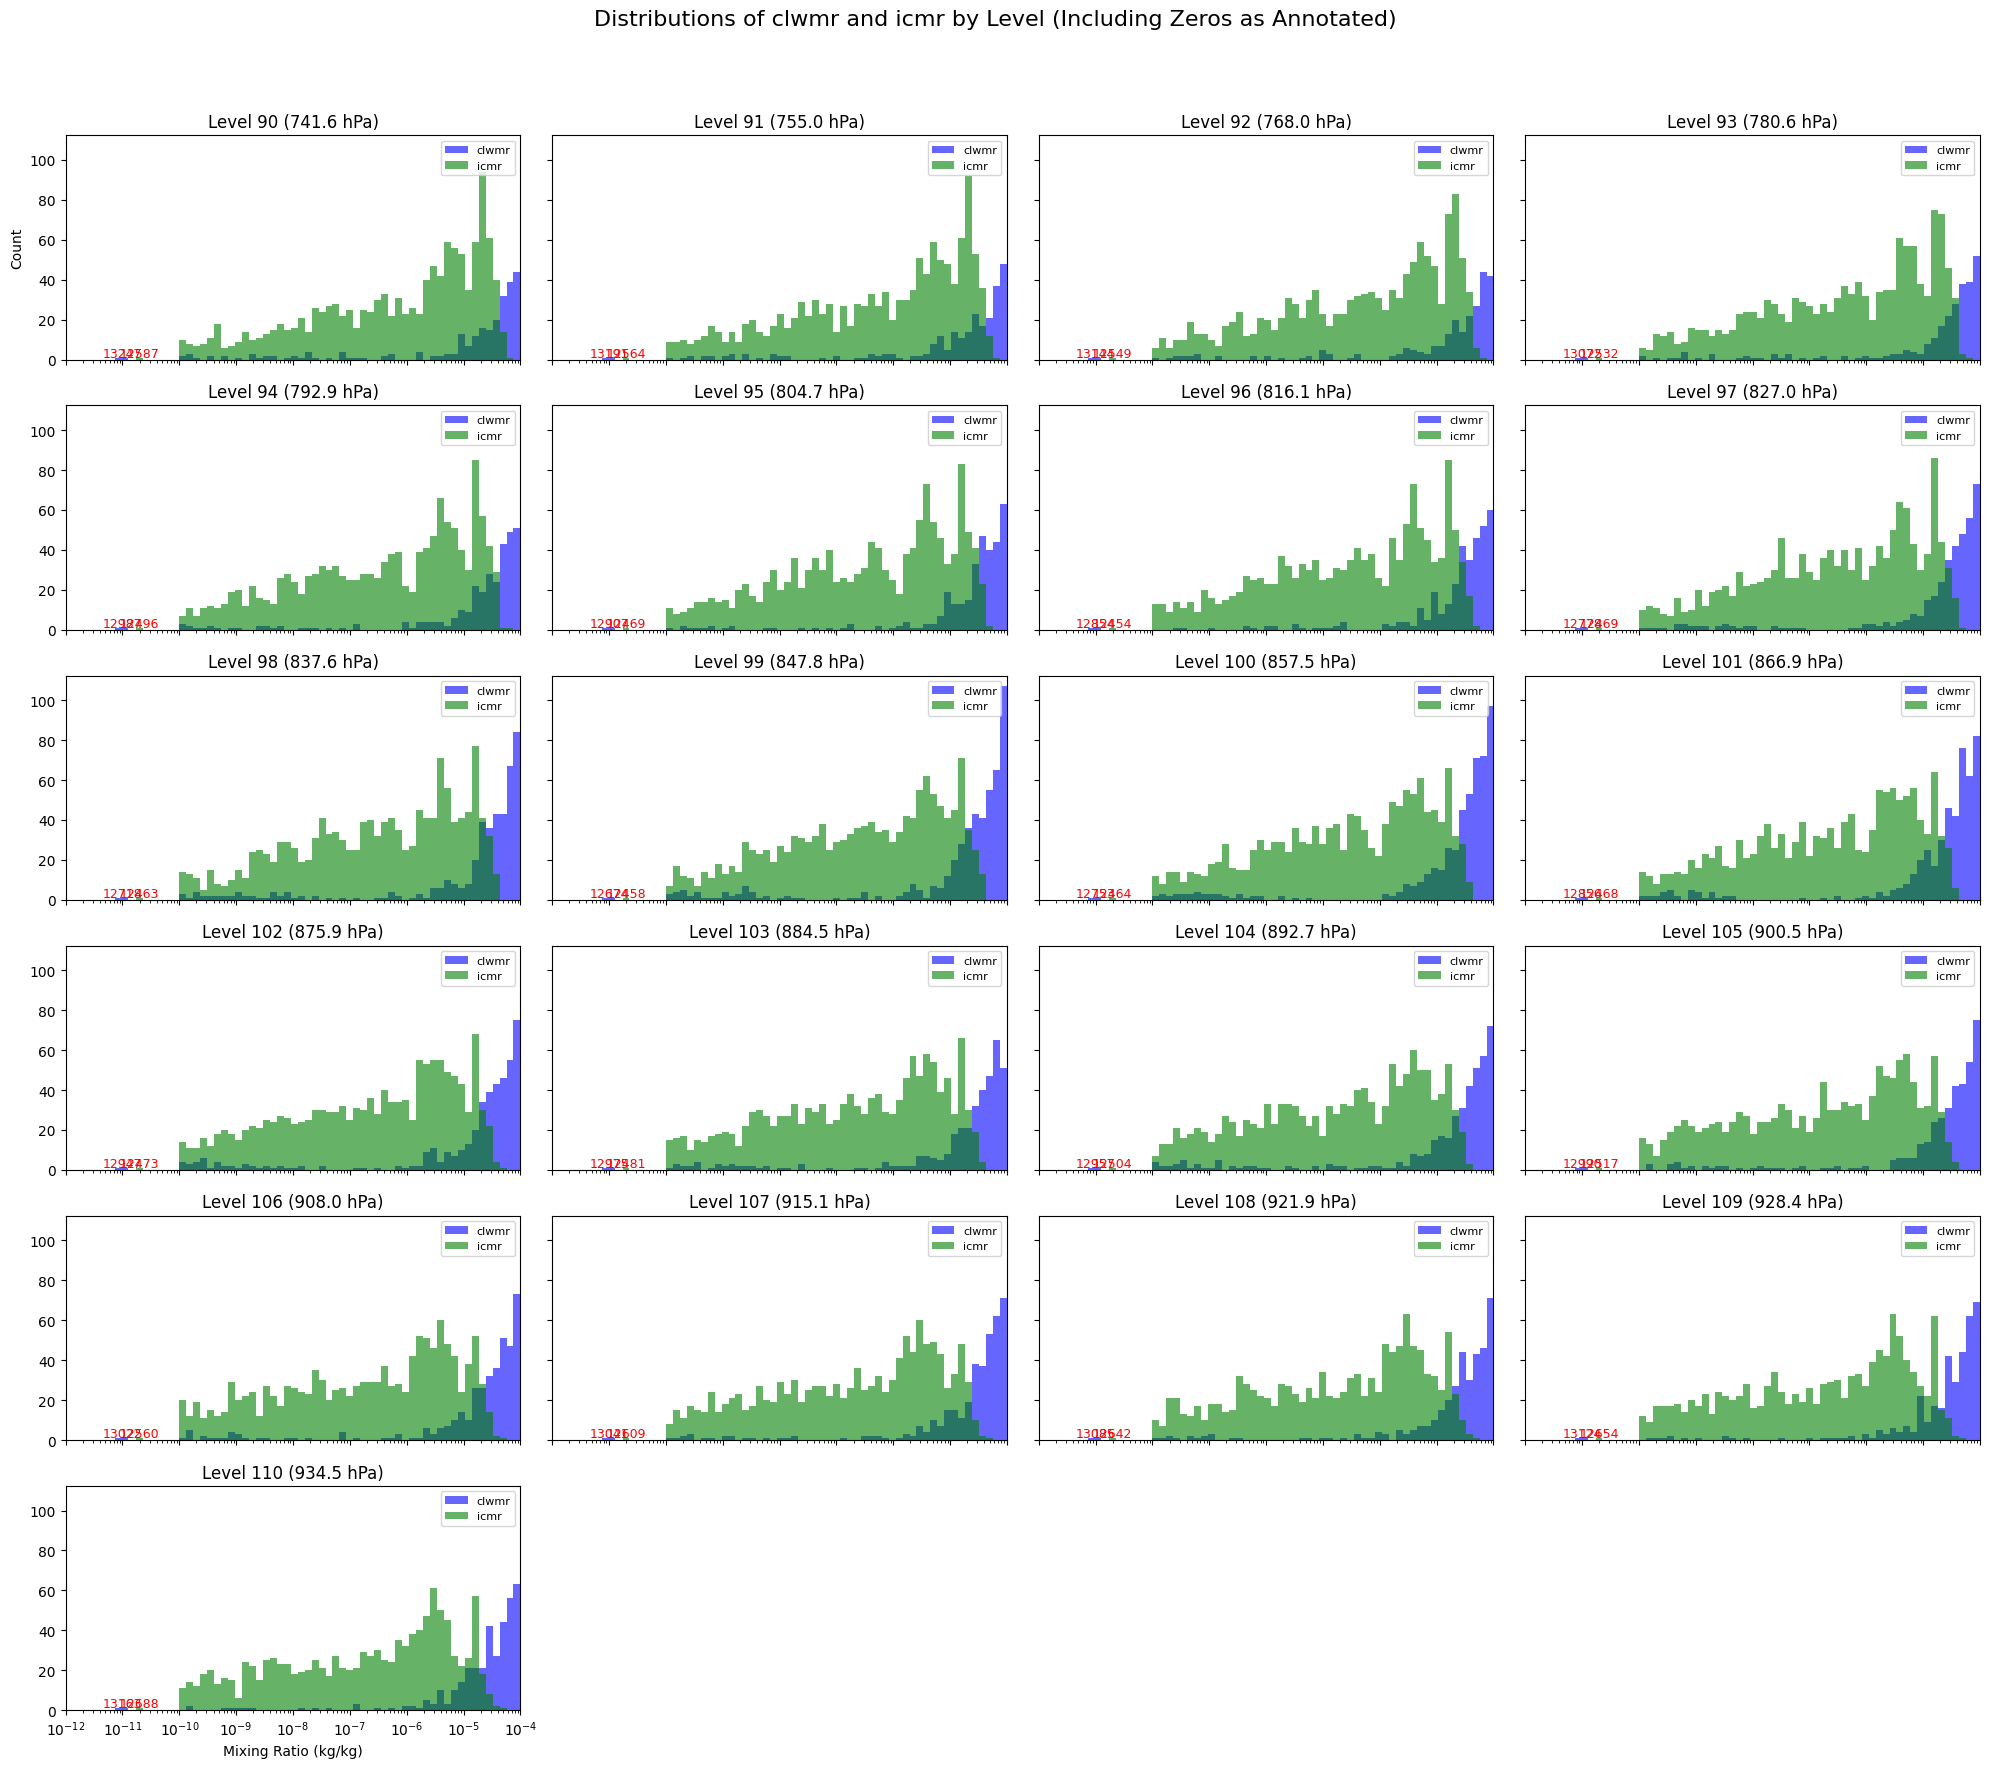

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
control_path = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
ds = xr.open_dataset(control_path)

# Time index and levels to check
time_index = 0
start_level = 90
end_level = 110
levels = list(range(start_level, end_level + 1))

# Get pressure levels if available
pfull = ds['pfull'].values if 'pfull' in ds else np.arange(ds.dims['pfull'])

# Plot setup
n_levels = len(levels)
ncols = 4
nrows = int(np.ceil(n_levels / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 3), sharex=True, sharey=True)
axs = axs.flatten()

# Define bins for non-zero part
log_bins = np.logspace(-10, -4, 50)

for i, lev in enumerate(levels):
    ax = axs[i]

    # Flatten all values
    cl = ds['clwmr'].isel(time=time_index, pfull=lev).values.flatten()
    ic = ds['icmr'].isel(time=time_index, pfull=lev).values.flatten()

    # Count zero values
    cl_zero_count = np.sum(cl <= 1e-10)
    ic_zero_count = np.sum(ic <= 1e-10)

    # Non-zero values
    cl_nonzero = cl[cl > 1e-10]
    ic_nonzero = ic[ic > 1e-10]

    # Plot non-zero part
    ax.hist(cl_nonzero, bins=log_bins, alpha=0.6, label='clwmr', color='blue')
    ax.hist(ic_nonzero, bins=log_bins, alpha=0.6, label='icmr', color='green')

    # Plot small visible bars at far left for zeros (so they're not invisible)
    ax.bar(1e-11, 1, width=5e-12, color='blue', alpha=0.6)
    ax.bar(2e-11, 1, width=5e-12, color='green', alpha=0.6)

    # Annotate counts above those bars
    ax.text(1e-11, 1.5, f'{cl_zero_count}', color='red', fontsize=9, ha='center')
    ax.text(2e-11, 1.5, f'{ic_zero_count}', color='red', fontsize=9, ha='center')

    ax.set_xscale('log')
    ax.set_xlim([1e-12, 1e-4])
    ax.set_title(f'Level {lev} ({pfull[lev]:.1f} hPa)' if 'pfull' in ds else f'Level {lev}')
    if i == 0:
        ax.set_ylabel('Count')
    if i >= len(axs) - ncols:
        ax.set_xlabel('Mixing Ratio (kg/kg)')

    ax.legend(loc='upper right', fontsize=8)

# Turn off unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.suptitle('Distributions of clwmr and icmr by Level (Including Zeros as Annotated)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/var/folders/_s/w0_bj1693_bg4hxwb34kxqr40000gt/T/ipykernel_61987/1744892837.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Type', y='log10_mixing_ratio', palette=['blue', 'green'])


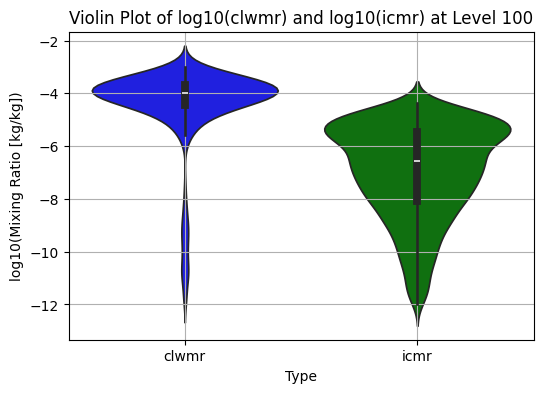

In [2]:
import seaborn as sns
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
control_path = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
ds = xr.open_dataset(control_path)

# Time index and levels to check
time_index = 0
start_level = 90
end_level = 110
levels = list(range(start_level, end_level + 1))

# Get pressure levels if available
pfull = ds['pfull'].values if 'pfull' in ds else np.arange(ds.dims['pfull'])

# Set up single level example for clarity
lev = 100
cl = ds['clwmr'].isel(time=0, pfull=lev).values.flatten()
ic = ds['icmr'].isel(time=0, pfull=lev).values.flatten()

# Filter and log-transform non-zero values
#cl_log = np.log10(cl[cl > 1e-12])
#ic_log = np.log10(ic[ic > 1e-12])

# Build DataFrame for seaborn
import pandas as pd
df = pd.DataFrame({
    'log10_mixing_ratio': np.concatenate([cl_log, ic_log]),
    'Type': ['clwmr'] * len(cl_log) + ['icmr'] * len(ic_log)
})

plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x='Type', y='log10_mixing_ratio', palette=['blue', 'green'])
plt.title(f'Violin Plot of log10(clwmr) and log10(icmr) at Level {lev}')
plt.ylabel('log10(Mixing Ratio [kg/kg])')
plt.grid(True)
plt.show()

IndexError: index 20 is out of bounds for axis 0 with size 20

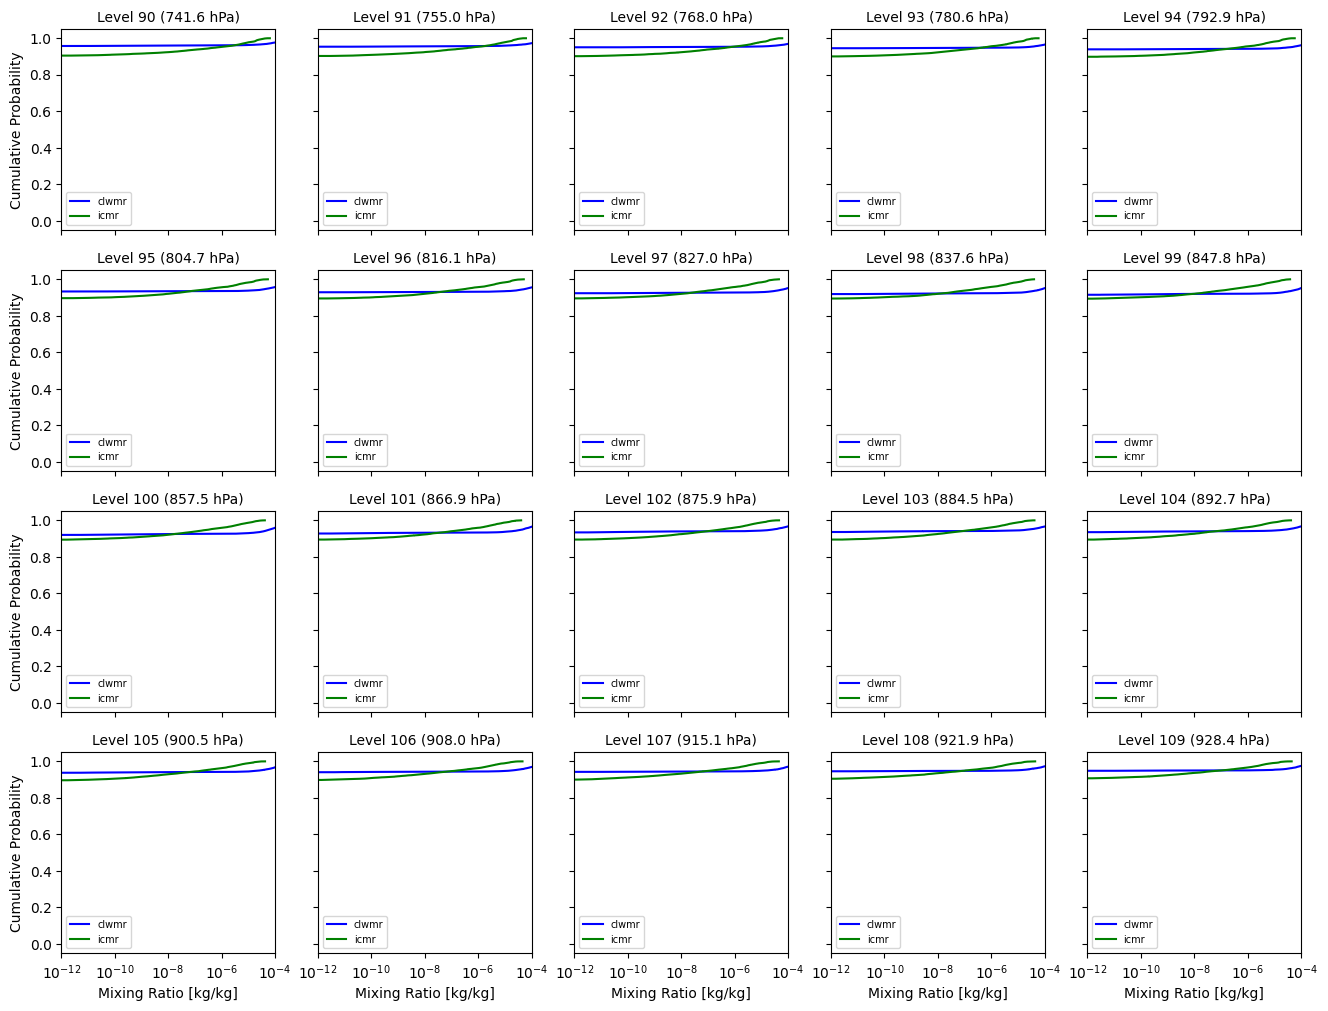

In [3]:
from statsmodels.distributions.empirical_distribution import ECDF

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(16, 12), sharex=True, sharey=True)
axs = axs.flatten()

for i, lev in enumerate(levels):
    ax = axs[i]
    cl = ds['clwmr'].isel(time=0, pfull=lev).values.flatten()
    ic = ds['icmr'].isel(time=0, pfull=lev).values.flatten()

    # Empirical CDFs (with zeros)
    cl_ecdf = ECDF(cl)
    ic_ecdf = ECDF(ic)

    ax.plot(cl_ecdf.x, cl_ecdf.y, label='clwmr', color='blue')
    ax.plot(ic_ecdf.x, ic_ecdf.y, label='icmr', color='green')

    ax.set_xscale('log')
    ax.set_xlim(1e-12, 1e-4)
    ax.set_title(f'Level {lev} ({pfull[lev]:.1f} hPa)' if 'pfull' in ds else f'Level {lev}', fontsize=10)
    if i % 5 == 0:
        ax.set_ylabel('Cumulative Probability')
    if i >= len(axs) - 5:
        ax.set_xlabel('Mixing Ratio [kg/kg]')

    ax.legend(fontsize=7)

# Hide extra subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.suptitle('ECDFs of clwmr and icmr by Level (Including Zeros)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

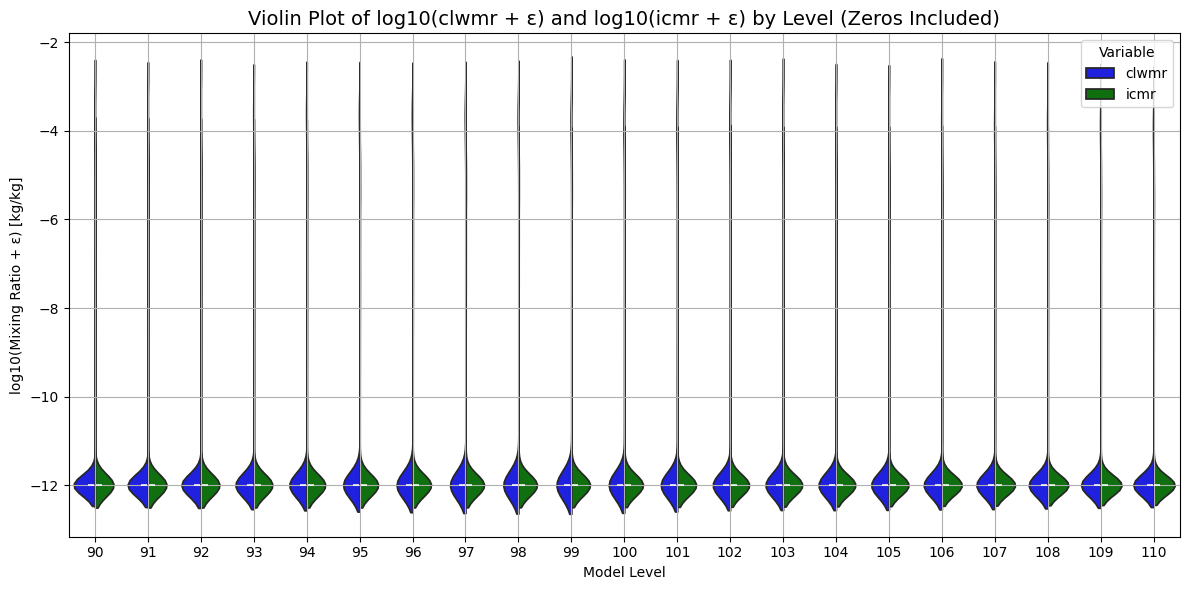

In [4]:
import seaborn as sns
import pandas as pd

log_eps = 1e-12  # small offset to include zeros

data = []
for lev in levels:
    cl = ds['clwmr'].isel(time=0, pfull=lev).values.flatten()
    ic = ds['icmr'].isel(time=0, pfull=lev).values.flatten()
    data += [(lev, 'clwmr', np.log10(x + log_eps)) for x in cl]
    data += [(lev, 'icmr', np.log10(x + log_eps)) for x in ic]

df = pd.DataFrame(data, columns=['Level', 'Type', 'log10_mixing'])

plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='Level', y='log10_mixing', hue='Type', palette=['blue', 'green'], split=True)
plt.title('Violin Plot of log10(clwmr + ε) and log10(icmr + ε) by Level (Zeros Included)', fontsize=14)
plt.ylabel('log10(Mixing Ratio + ε) [kg/kg]')
plt.xlabel('Model Level')
plt.legend(title='Variable')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF

# Load dataset
control_path = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
ds = xr.open_dataset(control_path)

# Select levels and time
time_index = 0
start_level = 90
end_level = 110
levels = list(range(start_level, end_level + 1))
log_eps = 1e-12  # small offset for log10 transform

/var/folders/_s/w0_bj1693_bg4hxwb34kxqr40000gt/T/ipykernel_61987/2725514676.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_violin, x='Variable', y='log10_mixing_ratio', palette=['blue', 'green'])


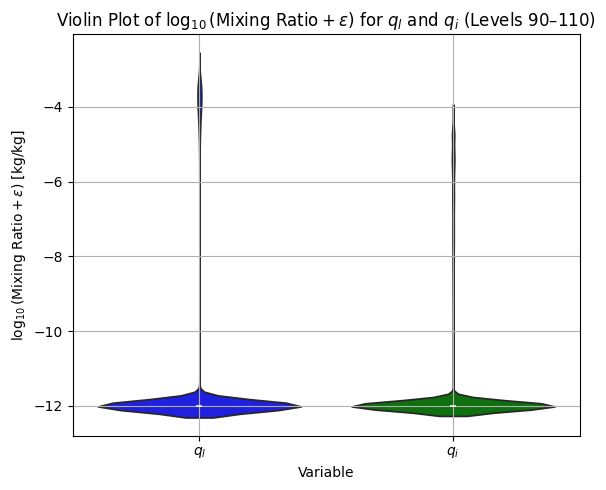

In [11]:
# Collect all values over levels
cl_vals = ds['clwmr'].isel(time=time_index, pfull=levels).values.flatten()
ic_vals = ds['icmr'].isel(time=time_index, pfull=levels).values.flatten()

# Apply log10(x + ε) to preserve zeros
df_violin = pd.DataFrame({
    'log10_mixing_ratio': np.log10(np.concatenate([cl_vals + log_eps, ic_vals + log_eps])),
    'Variable': ['clwmr'] * len(cl_vals) + ['icmr'] * len(ic_vals)
})

# Violin plot
plt.figure(figsize=(6, 5))
sns.violinplot(data=df_violin, x='Variable', y='log10_mixing_ratio', palette=['blue', 'green'])
plt.title(r'Violin Plot of $\log_{10}(\mathrm{Mixing\ Ratio} + \epsilon)$ for $q_l$ and $q_i$ (Levels 90–110)')
plt.ylabel(r'$\log_{10}(\mathrm{Mixing\ Ratio} + \epsilon)$ [kg/kg]')
plt.xticks([0, 1], [r'$q_l$', r'$q_i$'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Full values including zeros
cl = cl_vals
ic = ic_vals

# Compute ECDFs
ecdf_cl = ECDF(cl)
ecdf_ic = ECDF(ic)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(ecdf_q_l.x, ecdf_q_l.y, label=r'$q_l$', color='blue')
plt.plot(ecdf_q_i.x, ecdf_q_i.y, label=r'$q_i$', color='green')
plt.xscale('log')
plt.xlim(1e-12, 1e-4)
plt.xlabel(r'Mixing Ratio [kg/kg]')
plt.ylabel('Cumulative Probability')
plt.title(r'ECDF of $q_l$ and $q_i$ (Levels 90–110)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'ecdf_q_l' is not defined

<Figure size 600x500 with 0 Axes>

/var/folders/_s/w0_bj1693_bg4hxwb34kxqr40000gt/T/ipykernel_61987/4067545993.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_violin, x='Variable', y='log10_mixing_ratio', palette=['blue', 'green'])


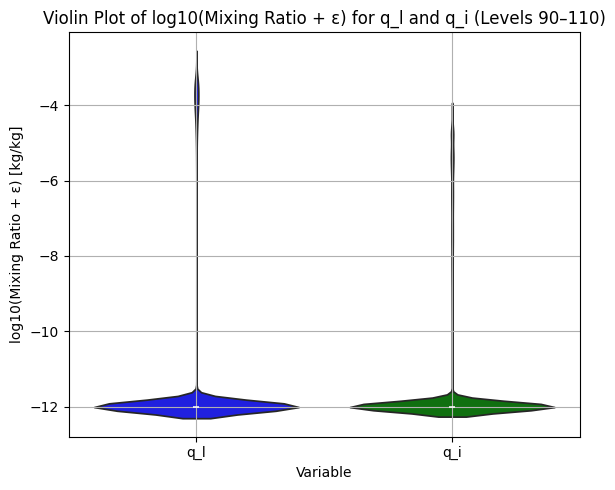

In [10]:
# Collect and rename
q_l_vals = ds['clwmr'].isel(time=time_index, pfull=levels).values.flatten()
q_i_vals = ds['icmr'].isel(time=time_index, pfull=levels).values.flatten()

# Log10 transform with epsilon for zeros
df_violin = pd.DataFrame({
    'log10_mixing_ratio': np.log10(np.concatenate([q_l_vals + log_eps, q_i_vals + log_eps])),
    'Variable': ['q_l'] * len(q_l_vals) + ['q_i'] * len(q_i_vals)
})

# Violin plot
plt.figure(figsize=(6, 5))
sns.violinplot(data=df_violin, x='Variable', y='log10_mixing_ratio', palette=['blue', 'green'])
plt.title('Violin Plot of log10(Mixing Ratio + ε) for q_l and q_i (Levels 90–110)')
plt.ylabel('log10(Mixing Ratio + ε) [kg/kg]')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

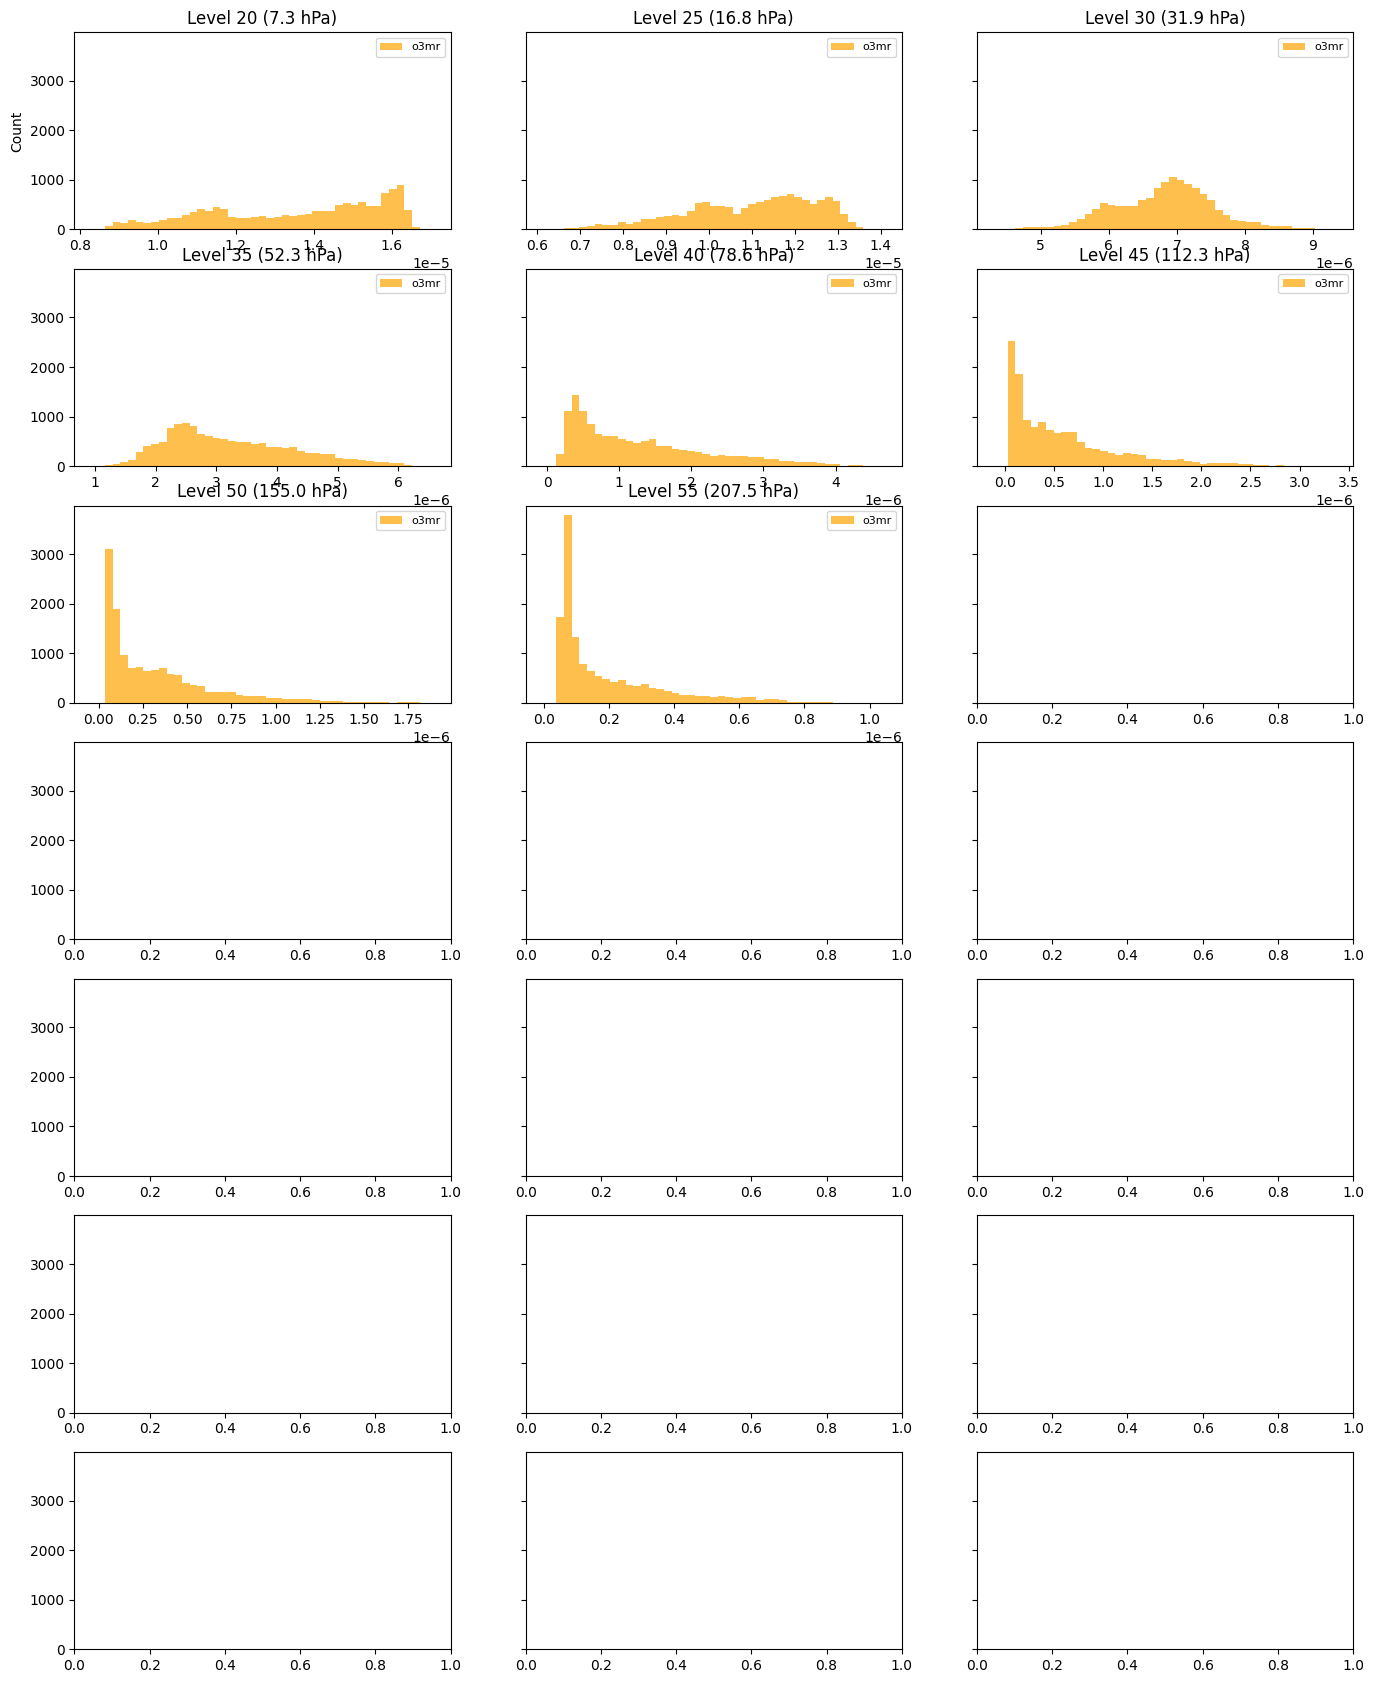

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
control_path = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/ens/control/mem001/cubed_sphere_grid_atmf003.nc'
ds = xr.open_dataset(control_path)

# Time index and selected levels (every 5th from 90 to 110)
time_index = 0
levels = list(range(20, 111, 5))  # 90, 95, 100, 105, 110

# Get pressure levels if available
pfull = ds['pfull'].values if 'pfull' in ds else np.arange(ds.dims['pfull'])

# Plot setup
n_levels = len(levels)
ncols = 3
nrows = int(np.ceil(n_levels / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5.5, nrows * 3), sharex=False, sharey=True)
axs = axs.flatten()

for i, lev in enumerate(levels):
    ax = axs[i]

    # Flatten and filter ozone values
    oz = ds['o3mr'].isel(time=time_index, pfull=lev).values.flatten()
    oz_nonzero = oz[oz > 0]

    if oz_nonzero.size == 0:
        ax.set_title(f'Level {lev} ({pfull[lev]:.1f} hPa)\n(No data)')
        ax.set_axis_off()
        continue

    # Linear bin range with padding
    vmin = oz_nonzero.min()
    vmax = oz_nonzero.max()
    padding = (vmax - vmin) * 0.1
    bins = np.linspace(vmin - padding, vmax + padding, 50)

    # Plot histogram
    ax.hist(oz_nonzero, bins=bins, alpha=0.7, color='orange', label='o3mr')
    ax.set_xlim(bins[0], bins[-1])

    ax.set_title(f'Level {lev} ({pfull[lev]:.1f} hPa)' if 'pfull' in ds else f'Level {lev}')
    if i == 0:
        ax.set_ylabel('Count')
    if i >= len(axs) - ncols:
        ax.set_xlabel('Mixing Ratio (kg/kg)')

    ax.legend(loc='upper right', fontsize=8)

# Turn off any unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.suptitle('Distributions of o3mr by Every 5th Level (Linear Scale)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Loading ensemble: 100%|██████████| 79/79 [17:03<00:00, 12.96s/it]


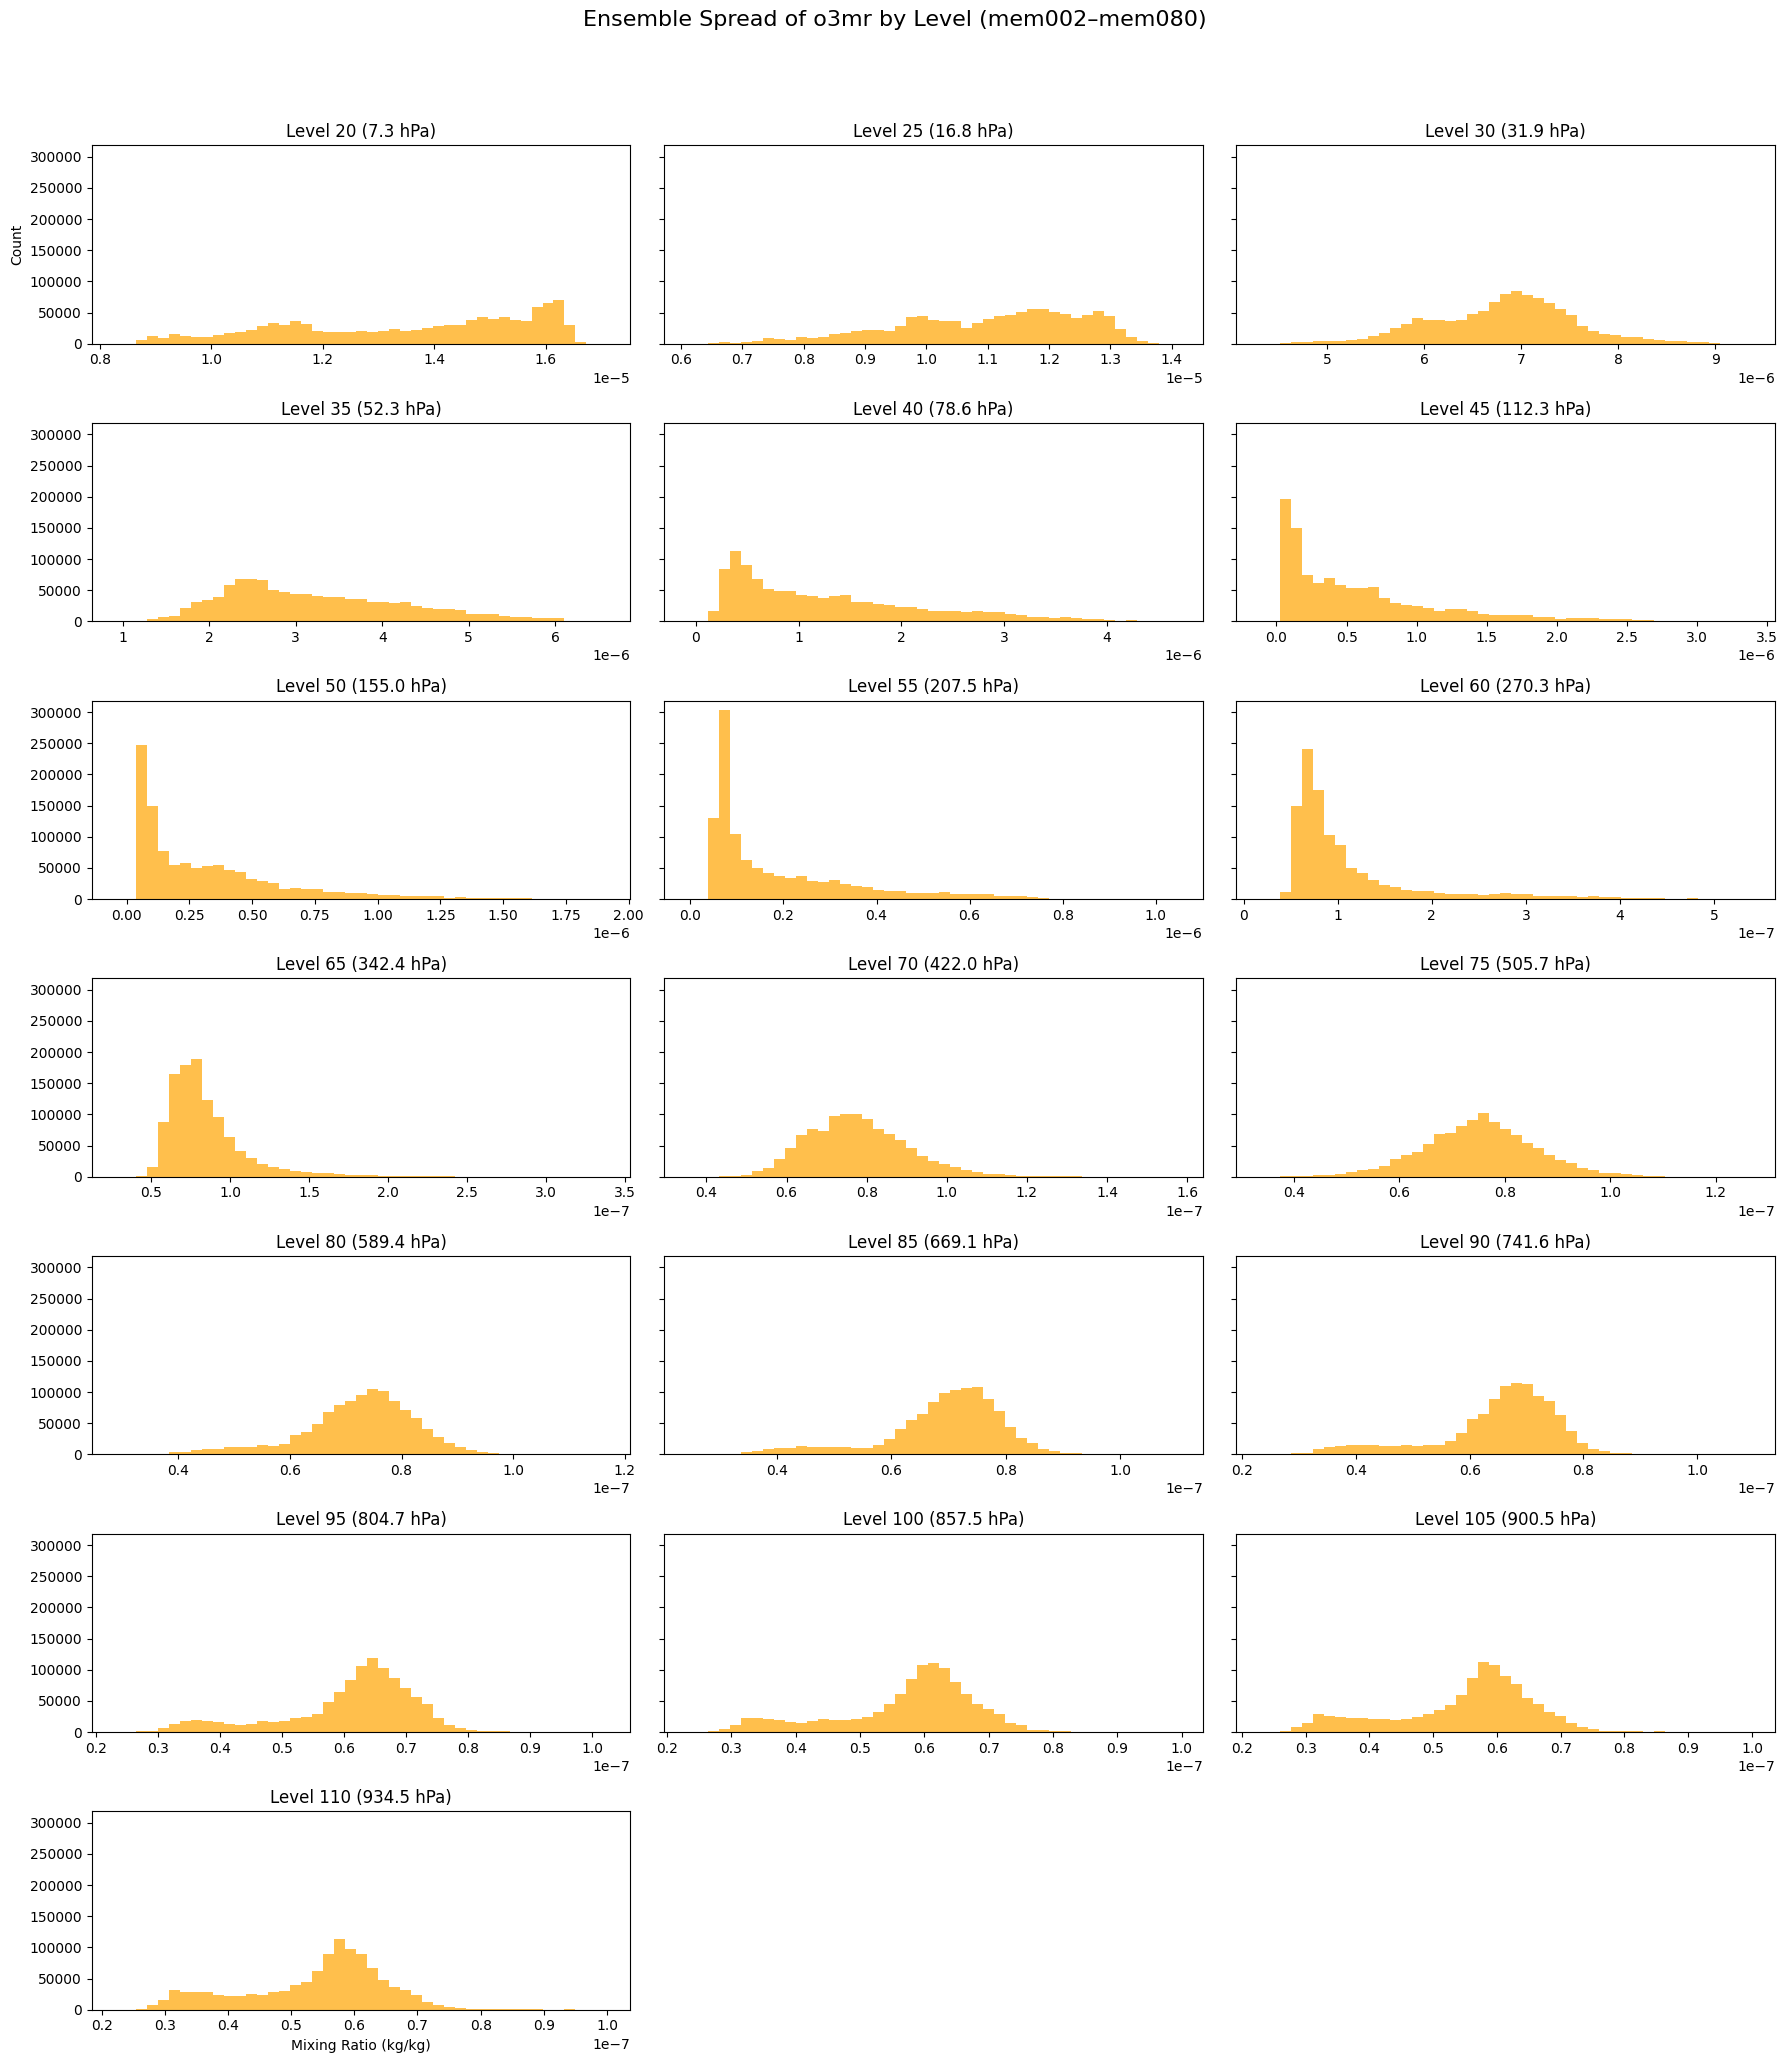

In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Base path and ensemble members
base_dir = '/Users/Joey/Volumes/orion//HybridTlm/Training/C48/Data/ens/test_htlm/'
members = [f'mem{m:03d}' for m in range(2, 81)]  # mem002 to mem080

# Time and levels
time_index = 0
levels = list(range(20, 111, 5))

# Load pfull from one sample file
sample_ds = xr.open_dataset(os.path.join(base_dir, members[0], 'cubed_sphere_grid_atmf003.nc'))
pfull = sample_ds['pfull'].values if 'pfull' in sample_ds else np.arange(sample_ds.dims['pfull'])

# Initialize dictionary: level -> list of ozone values across members
ozone_by_level = {lev: [] for lev in levels}

# Loop through members and collect o3mr
for mem in tqdm(members, desc='Loading ensemble'):
    file_path = os.path.join(base_dir, mem, 'cubed_sphere_grid_atmf003.nc')
    try:
        ds = xr.open_dataset(file_path)
        for lev in levels:
            data = ds['o3mr'].isel(time=time_index, pfull=lev).values.flatten()
            ozone_by_level[lev].append(data)
        ds.close()
    except Exception as e:
        print(f'Failed to read {file_path}: {e}')

# Plot histograms with shading for spread
ncols = 3
nrows = int(np.ceil(len(levels) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 3), sharey=True)
axs = axs.flatten()

for i, lev in enumerate(levels):
    ax = axs[i]

    # Stack member data [n_members, n_points]
    o3_data = np.stack(ozone_by_level[lev], axis=0)  # shape (n_members, n_points)
    
    # Remove zero or negative values
    o3_data = o3_data[o3_data > 0]
    if o3_data.size == 0:
        ax.set_title(f'Level {lev} ({pfull[lev]:.1f} hPa)\n(No data)')
        ax.axis('off')
        continue

    # Flatten and determine bins
    flat = o3_data.flatten()
    vmin, vmax = flat.min(), flat.max()
    padding = (vmax - vmin) * 0.1
    bins = np.linspace(vmin - padding, vmax + padding, 50)

    # Plot histogram for all members combined
    ax.hist(flat, bins=bins, color='orange', alpha=0.7)
    ax.set_xlim(bins[0], bins[-1])
    ax.set_title(f'Level {lev} ({pfull[lev]:.1f} hPa)')
    if i == 0:
        ax.set_ylabel('Count')
    if i >= len(axs) - ncols:
        ax.set_xlabel('Mixing Ratio (kg/kg)')

# Turn off unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.suptitle('Ensemble Spread of o3mr by Level (mem002–mem080)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [26]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Base directory and ensemble member list
base_dir = '/Users/Joey/Volumes/orion//HybridTlm/Training/C48/Data/ens/test_htlm/'
members = [f'mem{m:03d}' for m in range(2, 81)]  # mem002 to mem080

# Pressure levels of interest
levels = list(range(20, 111, 5))

# Forecast hours (003 to 009)
forecast_hours = range(3, 10)

# Load pfull from one sample file to get pressure values
sample_file = os.path.join(base_dir, members[0], 'cubed_sphere_grid_atmf003.nc')
sample_ds = xr.open_dataset(sample_file)
pfull = sample_ds['pfull'].values if 'pfull' in sample_ds else np.arange(sample_ds.dims['pfull'])

# Dictionary: hour -> [spread_by_level]
spread_by_hour = {}

# Loop over forecast hours
for hr in tqdm(forecast_hours, desc='Processing forecast hours'):
    fname = f'cubed_sphere_grid_atmf{hr:03d}.nc'
    spread_per_level = []

    for lev in levels:
        level_data = []

        for mem in members:
            fpath = os.path.join(base_dir, mem, fname)
            try:
                ds = xr.open_dataset(fpath)
                data = ds['o3mr'].isel(time=0, pfull=lev).values.flatten()
                data = data[data > 0]  # exclude zero/negative values
                if data.size > 0:
                    level_data.append(data.mean())  # use domain-mean at level
                ds.close()
            except Exception as e:
                print(f"Failed: {fpath} — {e}")

        # Compute spread (std deviation across members) at this level
        if level_data:
            spread = np.std(level_data)
        else:
            spread = np.nan
        spread_per_level.append(spread)

    spread_by_hour[hr] = spread_per_level

# === Plotting ===
plt.figure(figsize=(8, 6))
for hr in forecast_hours:
    spread = spread_by_hour[hr]
    plt.plot(spread, pfull[levels], label=f'Hour {hr - 3}', marker='o')

plt.gca().invert_yaxis()  # Pressure decreases upward
plt.xlabel('Ensemble Spread of o3mr (kg/kg)')
plt.ylabel('Pressure (hPa)')
plt.title('Ensemble Spread of o3mr vs. Pressure Level')
plt.legend(title='Forecast Hour')
plt.grid(True)
plt.tight_layout()
plt.show()

Processing forecast hours:  14%|█▍        | 1/7 [1:23:47<8:22:45, 5027.65s/it]

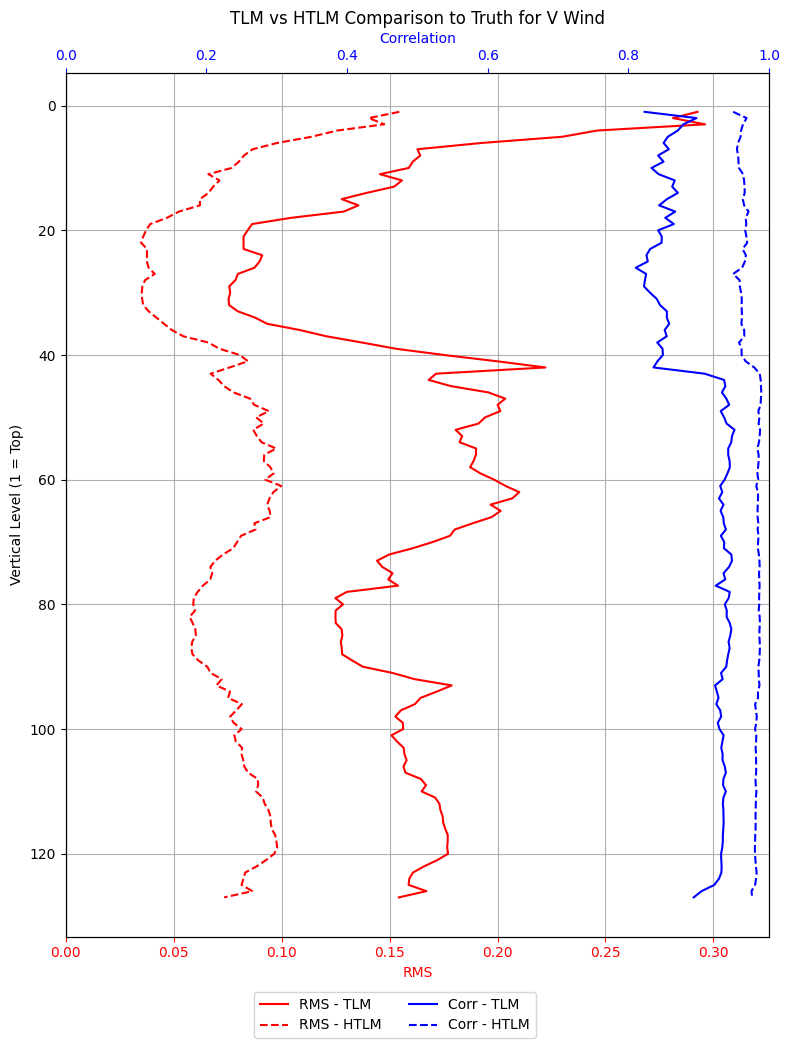

In [38]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# File paths
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem2_one_hour.nc'
file_htlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/htlm_forecast_cubed_sphere_mem2_one_hour.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf004.nc'

# Load datasets
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_truth = xr.open_dataset(file_truth)

# Align vertical levels (pfull)
ds_tlm = ds_tlm.assign_coords(pfull=ds_truth['pfull'])
ds_htlm = ds_htlm.assign_coords(pfull=ds_truth['pfull'])

# Extract vgrd (meridional wind increment) and convert to float64
v_truth = ds_truth['vgrd'].astype(np.float64).isel(time=0)
v_tlm = ds_tlm['vgrd'].astype(np.float64).isel(time=0)
v_htlm = ds_htlm['vgrd'].astype(np.float64).isel(time=0)

# Check shape consistency
assert v_truth.shape == v_tlm.shape == v_htlm.shape, "Shape mismatch in vgrd variables"

# Align data before correlation
v_tlm, v_truth = xr.align(v_tlm, v_truth)
v_htlm, _ = xr.align(v_htlm, v_truth)  # ensure same alignment

# Compute RMS and Correlation vs Truth
rms_tlm = np.sqrt(((v_tlm - v_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_tlm = xr.corr(v_tlm, v_truth, dim=('grid_yt', 'grid_xt'))

rms_htlm = np.sqrt(((v_htlm - v_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
corr_htlm = xr.corr(v_htlm, v_truth, dim=('grid_yt', 'grid_xt'))

# Average across tiles
rms_tlm_mean = rms_tlm.mean(dim='tile')
corr_tlm_mean = corr_tlm.mean(dim='tile')

rms_htlm_mean = rms_htlm.mean(dim='tile')
corr_htlm_mean = corr_htlm.mean(dim='tile')

# Get vertical levels index (1 = top)
levels = np.arange(1, len(rms_tlm['pfull']) + 1)

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 10))

# Plot RMS
ax1.plot(rms_tlm_mean, levels, 'r-', label='RMS - TLM')
ax1.plot(rms_htlm_mean, levels, 'r--', label='RMS - HTLM')
ax1.set_xlabel('RMS', color='red')
ax1.tick_params(axis='x', colors='red')
ax1.set_ylabel('Vertical Level (1 = Top)')
ax1.set_xlim(0, rms_tlm_mean.max() * 1.1)  # Fix RMS axis range
ax1.invert_yaxis()
ax1.grid(True)

# Twin axis for correlation
ax2 = ax1.twiny()
ax2.plot(corr_tlm_mean, levels, 'b-', label='Corr - TLM')
ax2.plot(corr_htlm_mean, levels, 'b--', label='Corr - HTLM')
ax2.set_xlabel('Correlation', color='blue')
ax2.tick_params(axis='x', colors='blue')
ax2.set_xlim(0, 1)  # Fix correlation axis range

# Title and legend
plt.title('TLM vs HTLM Comparison to Truth for V Wind')
fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()

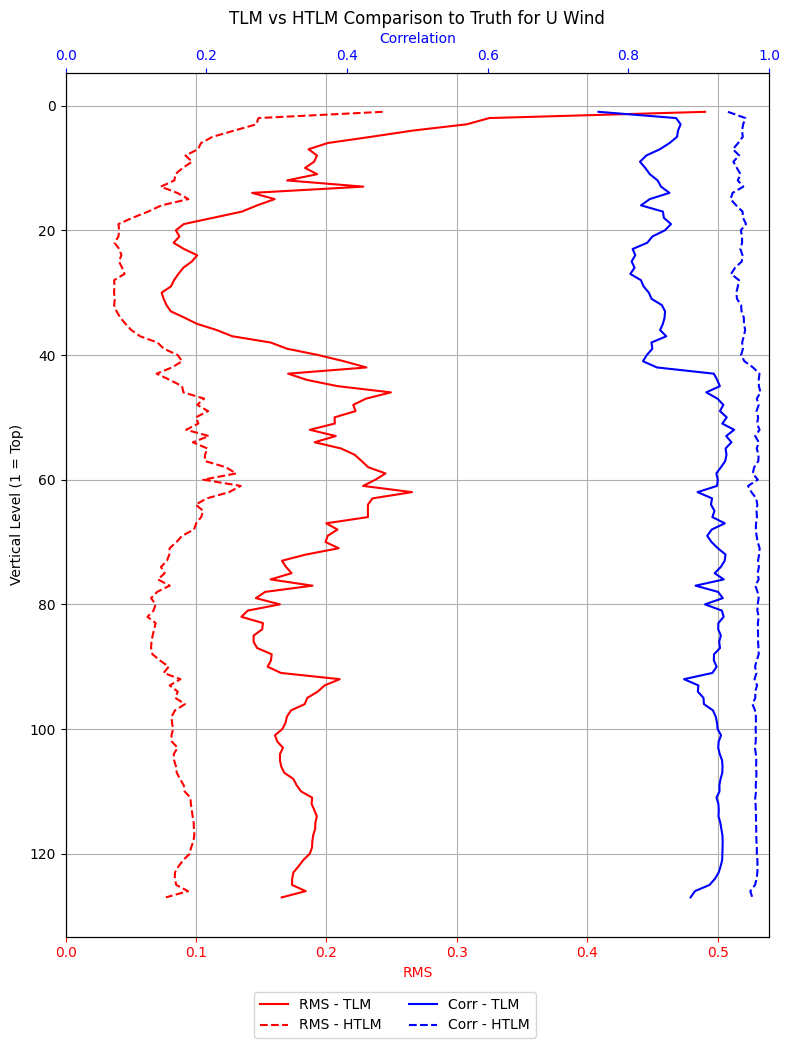

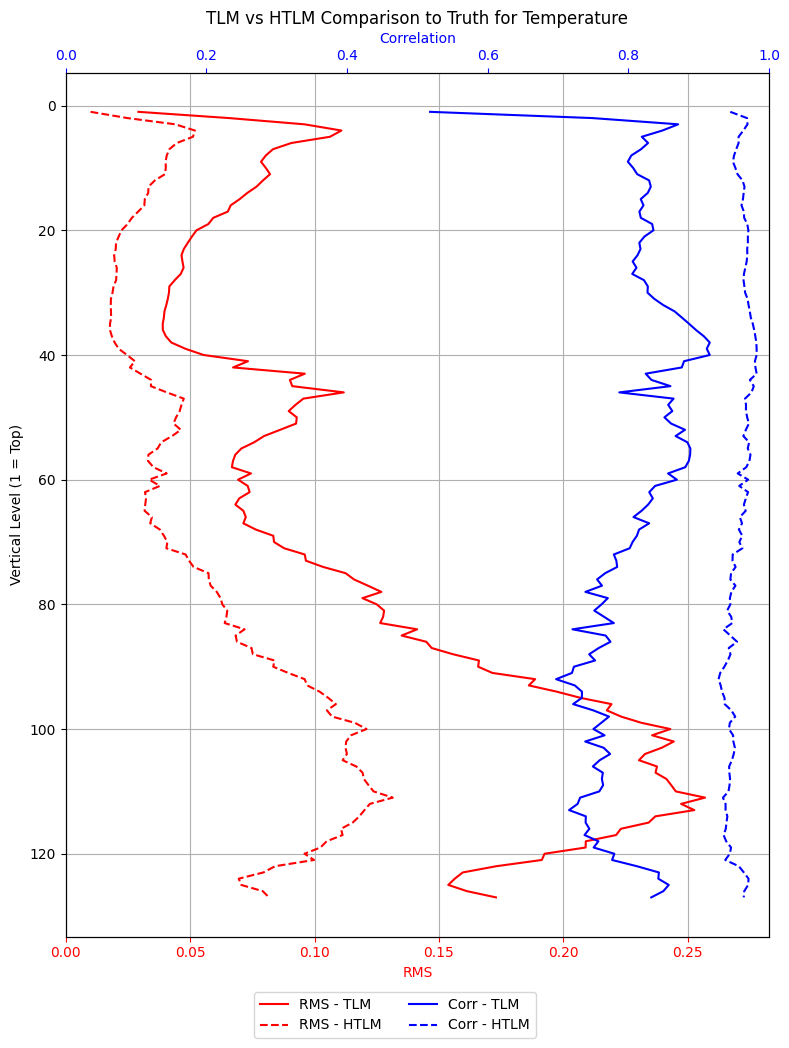

In [39]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# File paths
file_tlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output/tlm_forecast_cubed_sphere_mem2_one_hour.nc'
file_htlm = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/htlm_output/htlm_forecast_cubed_sphere_mem2_one_hour.nc'
file_truth = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf004.nc'

# Load datasets
ds_tlm = xr.open_dataset(file_tlm)
ds_htlm = xr.open_dataset(file_htlm)
ds_truth = xr.open_dataset(file_truth)

# Align vertical levels (pfull)
ds_tlm = ds_tlm.assign_coords(pfull=ds_truth['pfull'])
ds_htlm = ds_htlm.assign_coords(pfull=ds_truth['pfull'])

def compute_rms_corr(varname, label):
    # Extract variables
    v_truth = ds_truth[varname].astype(np.float64).isel(time=0)
    v_tlm = ds_tlm[varname].astype(np.float64).isel(time=0)
    v_htlm = ds_htlm[varname].astype(np.float64).isel(time=0)

    # Check shape consistency
    assert v_truth.shape == v_tlm.shape == v_htlm.shape, f"Shape mismatch in {varname}"

    # Align
    v_tlm, v_truth = xr.align(v_tlm, v_truth)
    v_htlm, _ = xr.align(v_htlm, v_truth)

    # Compute RMS and Correlation vs Truth
    rms_tlm = np.sqrt(((v_tlm - v_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
    corr_tlm = xr.corr(v_tlm, v_truth, dim=('grid_yt', 'grid_xt'))

    rms_htlm = np.sqrt(((v_htlm - v_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
    corr_htlm = xr.corr(v_htlm, v_truth, dim=('grid_yt', 'grid_xt'))

    # Average across tiles
    rms_tlm_mean = rms_tlm.mean(dim='tile')
    corr_tlm_mean = corr_tlm.mean(dim='tile')
    rms_htlm_mean = rms_htlm.mean(dim='tile')
    corr_htlm_mean = corr_htlm.mean(dim='tile')

    # Plotting
    levels = np.arange(1, len(rms_tlm['pfull']) + 1)
    fig, ax1 = plt.subplots(figsize=(8, 10))

    ax1.plot(rms_tlm_mean, levels, 'r-', label='RMS - TLM')
    ax1.plot(rms_htlm_mean, levels, 'r--', label='RMS - HTLM')
    ax1.set_xlabel('RMS', color='red')
    ax1.tick_params(axis='x', colors='red')
    ax1.set_ylabel('Vertical Level (1 = Top)')
    ax1.set_xlim(0, rms_tlm_mean.max() * 1.1)
    ax1.invert_yaxis()
    ax1.grid(True)

    ax2 = ax1.twiny()
    ax2.plot(corr_tlm_mean, levels, 'b-', label='Corr - TLM')
    ax2.plot(corr_htlm_mean, levels, 'b--', label='Corr - HTLM')
    ax2.set_xlabel('Correlation', color='blue')
    ax2.tick_params(axis='x', colors='blue')
    ax2.set_xlim(0, 1)

    plt.title(f'TLM vs HTLM Comparison to Truth for {label}')
    fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
    plt.tight_layout()
    plt.show()

# Run for ugrd and tmp
compute_rms_corr('ugrd', 'U Wind')
compute_rms_corr('tmp', 'Temperature')

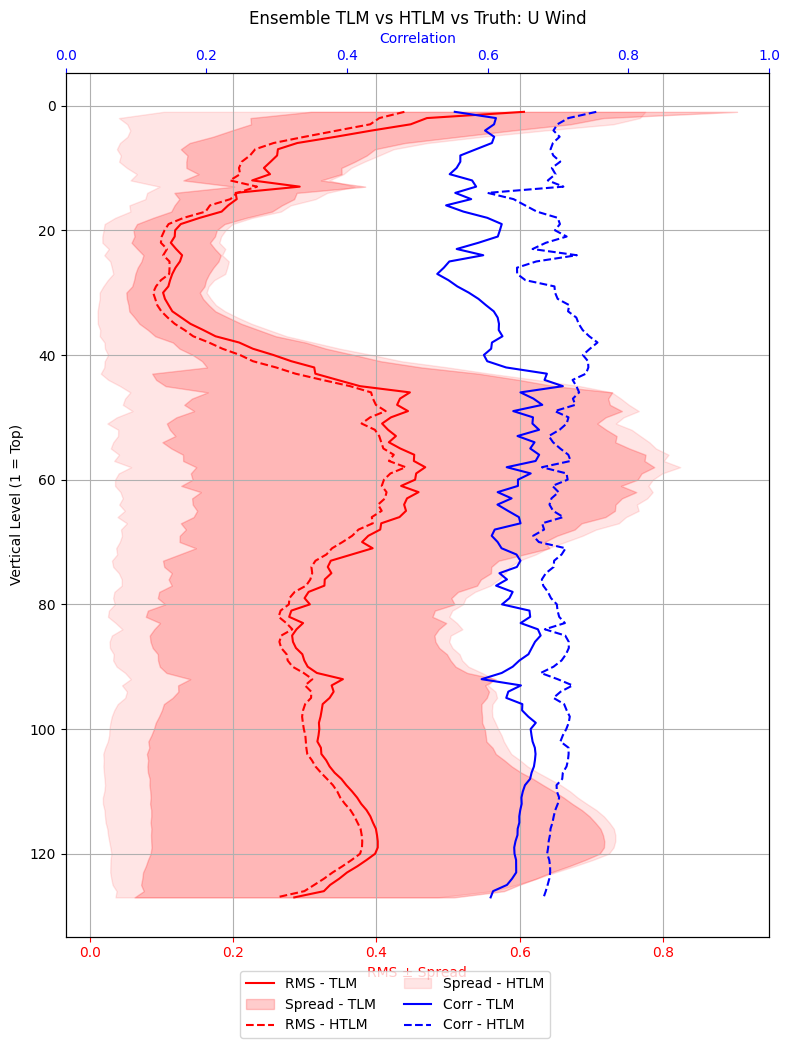

KeyboardInterrupt: 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths
tlm_dir = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/tlm_output'
htlm_dir = '/Users/Joey/Volumes/orion/JediCode/hybrid_tlm/fv3-jedi-htlm/htlm_output'
truth_file = '/Users/Joey/Volumes/orion/HybridTlm/Training/C48/Data/diff_from_control/diff_mem002_cubed_sphere_grid_atmf004.nc'

# Load truth
ds_truth = xr.open_dataset(truth_file)

# Load all ensemble members
def load_ensemble_averages(varname, base_dir, prefix):
    members = []
    for i in range(2, 81):
        mem_id = f"mem{str(i).zfill(3)}"
        filename = f"{prefix}_forecast_cubed_sphere_{mem_id}_one_hour.nc"
        full_path = os.path.join(base_dir, filename)
        if not os.path.exists(full_path):
            print(f"WARNING: Missing {full_path}, skipping...")
            continue
        ds = xr.open_dataset(full_path)
        ds = ds.assign_coords(pfull=ds_truth['pfull'])  # Align vertical levels
        members.append(ds[varname].astype(np.float64).isel(time=0).expand_dims(ensemble=[i]))
    return xr.concat(members, dim='ensemble')

# Compute and plot RMS/correlation with spread
def compute_rms_corr_ensemble(varname, label):
    v_truth = ds_truth[varname].astype(np.float64).isel(time=0)

    # Load TLM and HTLM ensembles
    v_tlm_ens = load_ensemble_averages(varname, tlm_dir, 'tlm')
    v_htlm_ens = load_ensemble_averages(varname, htlm_dir, 'htlm')

    # Check shapes
    assert v_tlm_ens.shape[1:] == v_truth.shape, f"Shape mismatch for {varname}"

    # Align
    v_tlm_ens, v_truth = xr.align(v_tlm_ens, v_truth)
    v_htlm_ens, _ = xr.align(v_htlm_ens, v_truth)

    # Mean and spread
    v_tlm_mean = v_tlm_ens.mean(dim='ensemble')
    v_tlm_std = v_tlm_ens.std(dim='ensemble')
    v_htlm_mean = v_htlm_ens.mean(dim='ensemble')
    v_htlm_std = v_htlm_ens.std(dim='ensemble')

    # RMS
    rms_tlm = np.sqrt(((v_tlm_mean - v_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))
    rms_htlm = np.sqrt(((v_htlm_mean - v_truth) ** 2).mean(dim=('grid_yt', 'grid_xt')))

    # Spread
    spread_tlm = v_tlm_std.mean(dim=('grid_yt', 'grid_xt'))
    spread_htlm = v_htlm_std.mean(dim=('grid_yt', 'grid_xt'))

    # Correlation
    corr_tlm = xr.corr(v_tlm_mean, v_truth, dim=('grid_yt', 'grid_xt'))
    corr_htlm = xr.corr(v_htlm_mean, v_truth, dim=('grid_yt', 'grid_xt'))

    # Average over tiles
    rms_tlm_mean = rms_tlm.mean(dim='tile')
    rms_htlm_mean = rms_htlm.mean(dim='tile')
    spread_tlm_mean = spread_tlm.mean(dim='tile')
    spread_htlm_mean = spread_htlm.mean(dim='tile')
    corr_tlm_mean = corr_tlm.mean(dim='tile')
    corr_htlm_mean = corr_htlm.mean(dim='tile')

    # Plotting
    levels = np.arange(1, len(rms_tlm['pfull']) + 1)
    fig, ax1 = plt.subplots(figsize=(8, 10))

    # RMS lines with spread shading
    ax1.plot(rms_tlm_mean, levels, 'r-', label='RMS - TLM')
    ax1.fill_betweenx(levels,
                      rms_tlm_mean - spread_tlm_mean,
                      rms_tlm_mean + spread_tlm_mean,
                      color='r', alpha=0.2, label='Spread - TLM')

    ax1.plot(rms_htlm_mean, levels, 'r--', label='RMS - HTLM')
    ax1.fill_betweenx(levels,
                      rms_htlm_mean - spread_htlm_mean,
                      rms_htlm_mean + spread_htlm_mean,
                      color='r', alpha=0.1, label='Spread - HTLM')

    ax1.set_xlabel('RMS ± Spread', color='red')
    ax1.tick_params(axis='x', colors='red')
    ax1.set_ylabel('Vertical Level (1 = Top)')
    ax1.invert_yaxis()
    ax1.grid(True)

    # Correlation (twin x-axis)
    ax2 = ax1.twiny()
    ax2.plot(corr_tlm_mean, levels, 'b-', label='Corr - TLM')
    ax2.plot(corr_htlm_mean, levels, 'b--', label='Corr - HTLM')
    ax2.set_xlabel('Correlation', color='blue')
    ax2.tick_params(axis='x', colors='blue')
    ax2.set_xlim(0, 1)

    plt.title(f'Ensemble TLM vs HTLM vs Truth: {label}')
    fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
    plt.tight_layout()
    plt.show()

# Run for multiple variables
compute_rms_corr_ensemble('ugrd', 'U Wind')
compute_rms_corr_ensemble('vgrd', 'V Wind')
compute_rms_corr_ensemble('tmp', 'Temperature')